In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm import tqdm
import ephem

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Compute beta0
g  = 9.81  # m s-2
qb = 0.02  # kg/kg
L  = 2.5e6 # J/kg
Cp = 1e3   # J/kg/K
# dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.sst_pmd / (g * qb * L)
dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.temp_pmd / (g * qb * L)
dsg['beta0_T0'] = (dsg.uc ** 2) * Cp / (g * qb * L)

# # Rel SST
# dsg['rel_sst'] = dsg.sst_pmd - dsg.trop_sst_rms

# Group by basin
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016

for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0]

100%|██████████████████████████████████████| 1208/1208 [00:03<00:00, 379.69it/s]


In [47]:
cond = (dsg.center_quality_flag < 2) & (dsg.percent_outside < 50) & (abs(dsg.lat) < 30) & (dsg.rmx < 100000) & (dsg.vmx > 33) & (~np.isnan(dsg.sst_rms)) & (~np.isnan(dsg.r34))
d    = dsg.where(cond, drop=True)

### 1) Preliminary diagnostic

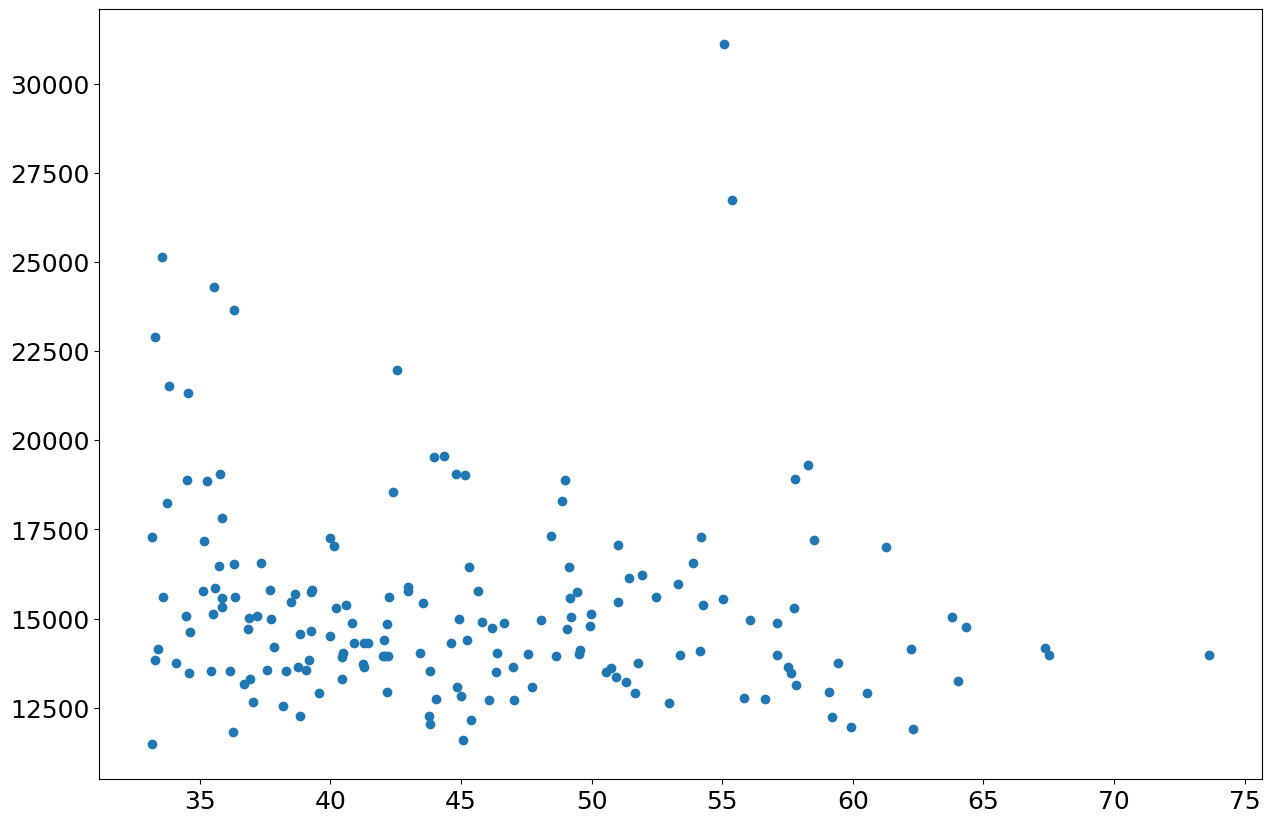

In [48]:
plt.scatter(d.vmx, d.beta0_pmd)

Text(0, 0.5, 'beta0 SAR')

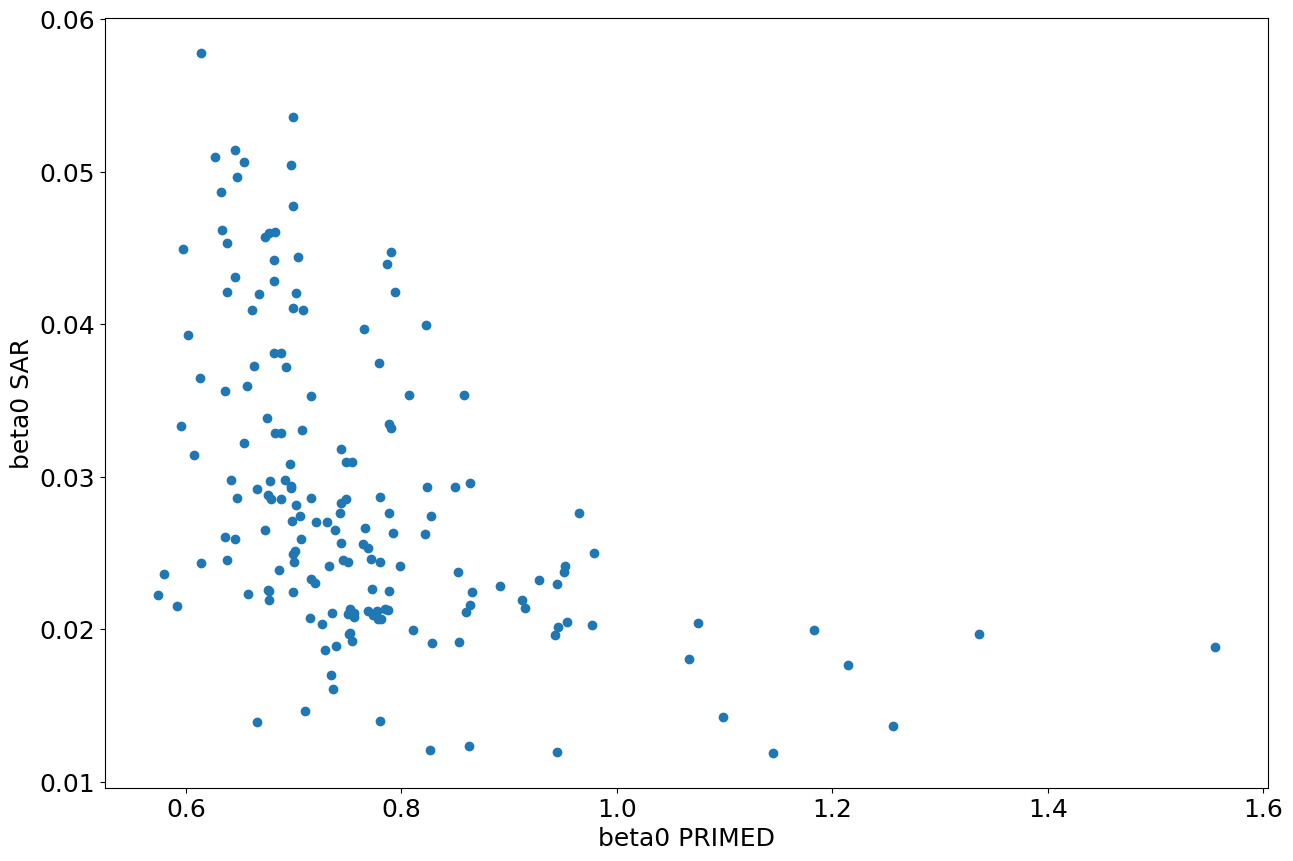

In [49]:
plt.scatter(d.beta0_pmd / 20000, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

Text(0, 0.5, 'beta0 SAR')

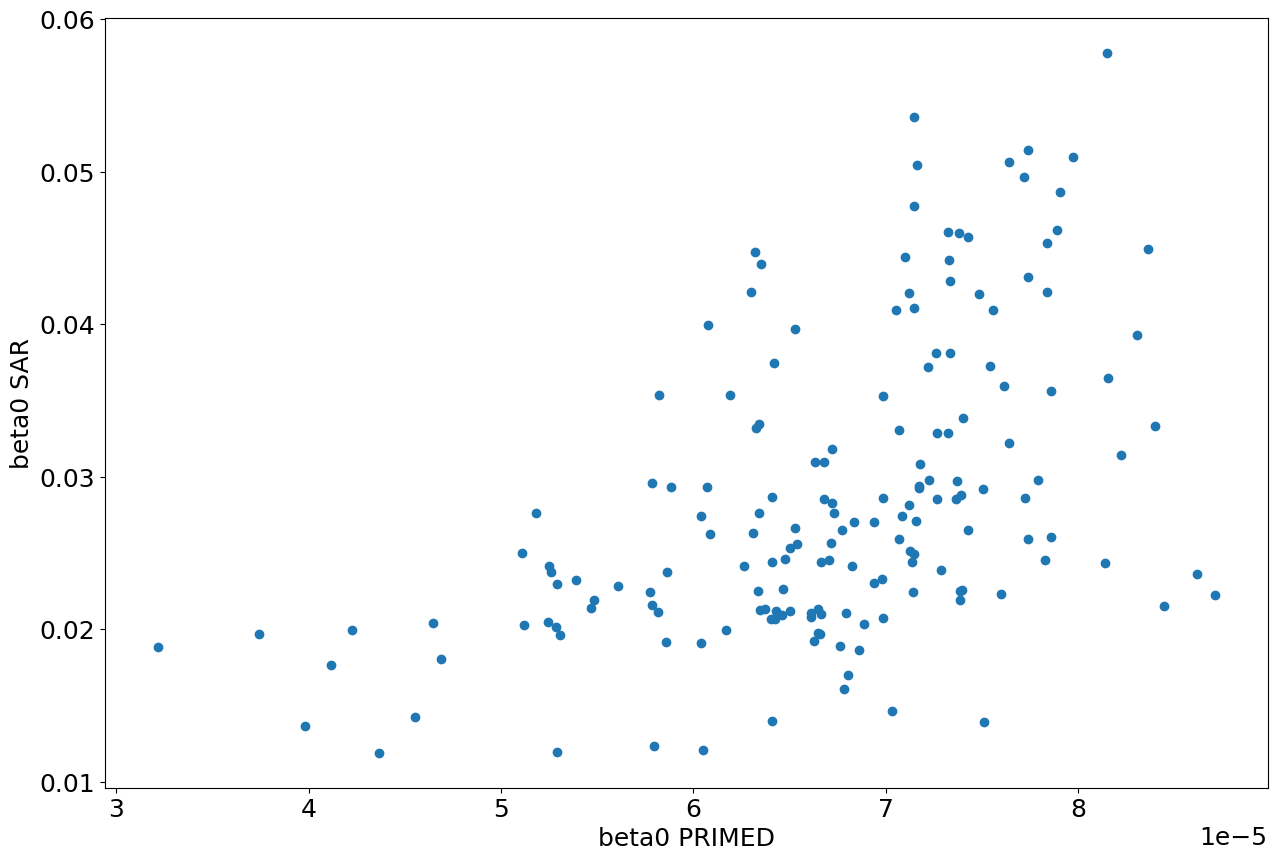

In [50]:
plt.scatter(1/ d.beta0_pmd, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

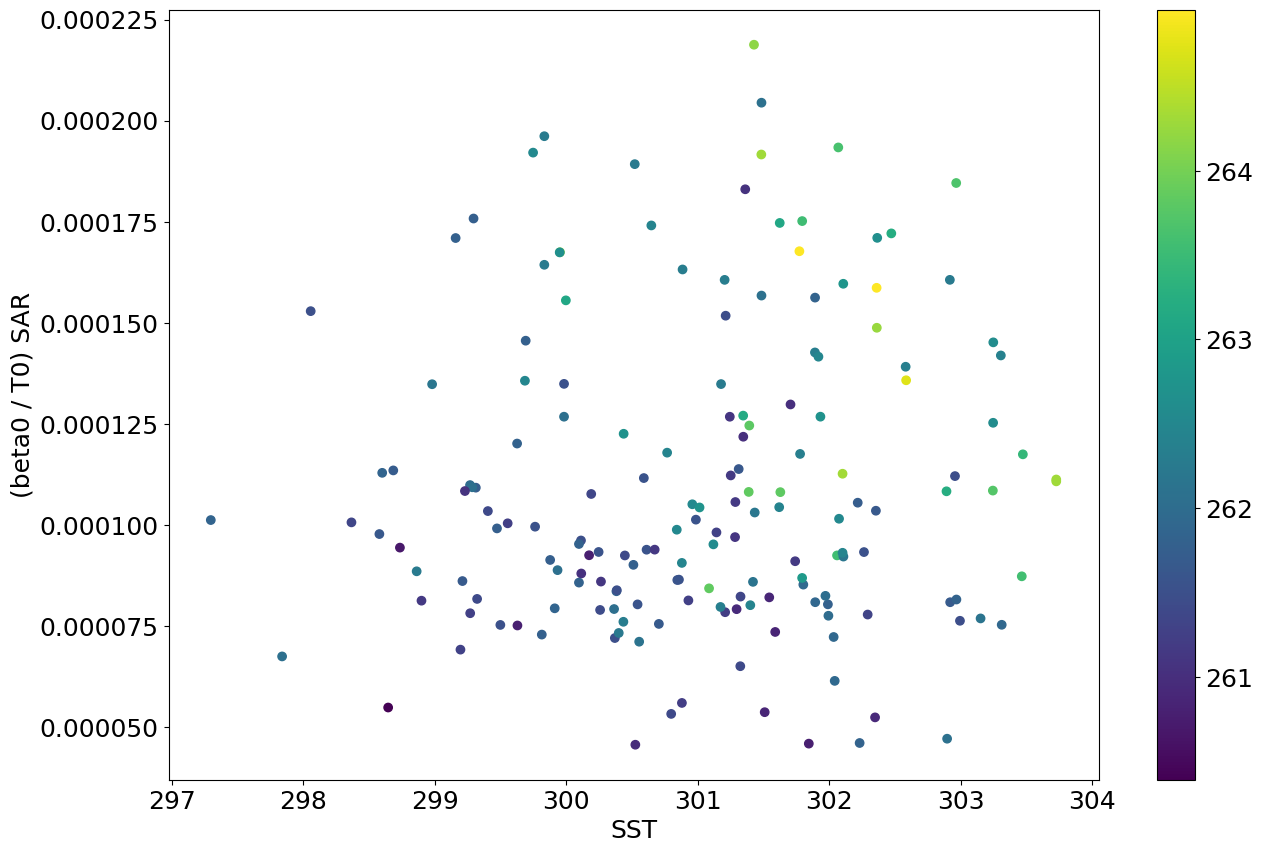

In [51]:
plt.scatter(d.sst_rms, d.beta0_T0 / 20000, c=d.temp_pmd)
plt.xlabel('SST')
plt.ylabel('(beta0 / T0) SAR')
plt.colorbar()
# plt.xlim(0, 1)

In [52]:
# plt.scatter(d.beta0_T0_pmd / 20000, d.beta0_T0 / 20000)
# plt.xlabel('beta0 / T0 PRIMED')
# plt.ylabel('beta0 / T0 SAR')
# # plt.xlim(0, 0.005)

Text(0, 0.5, 'Holland B')

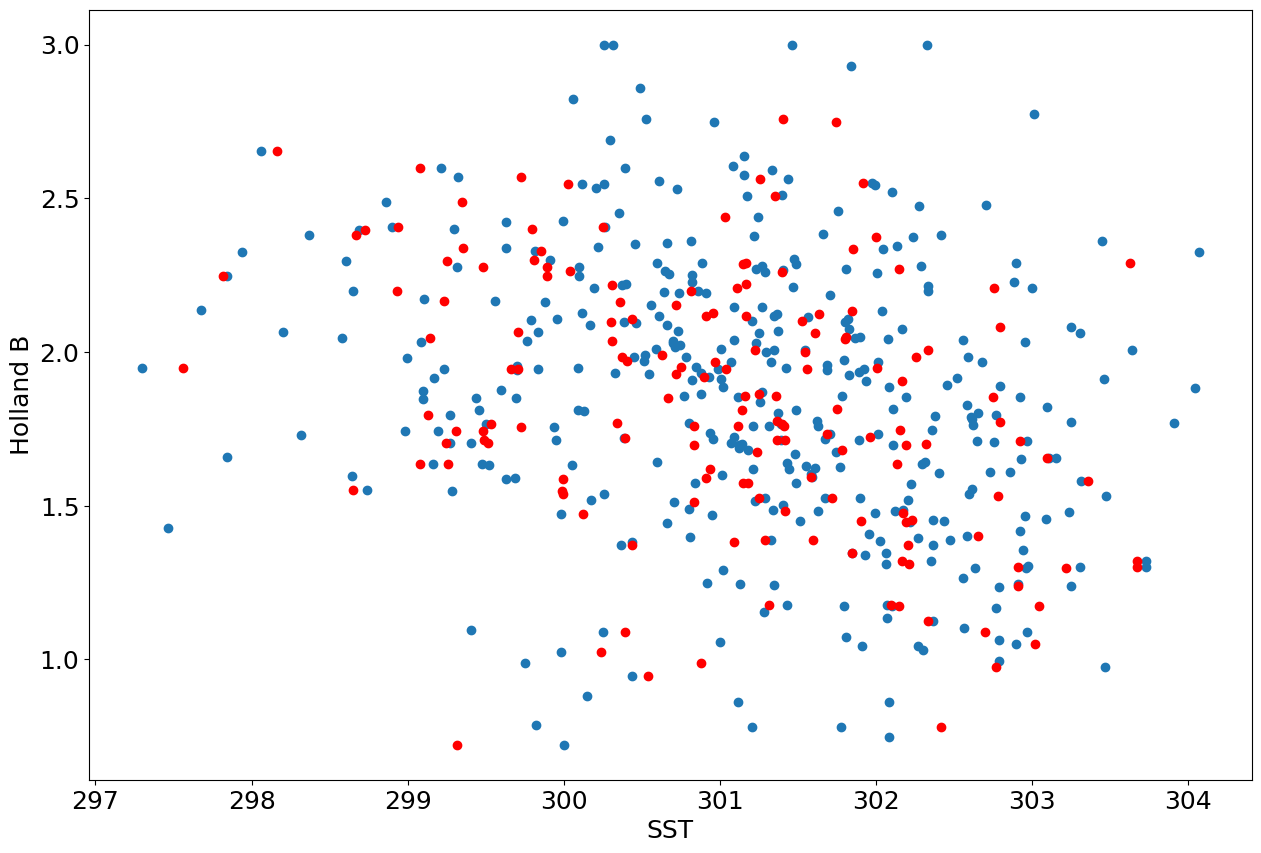

In [53]:
plt.scatter(d.sst_rms, d.B_hol)
plt.scatter(d.sst_pmd, d.B_hol, c='r')
plt.xlabel('SST')
plt.ylabel('Holland B')

Text(0, 0.5, 'Holland B')

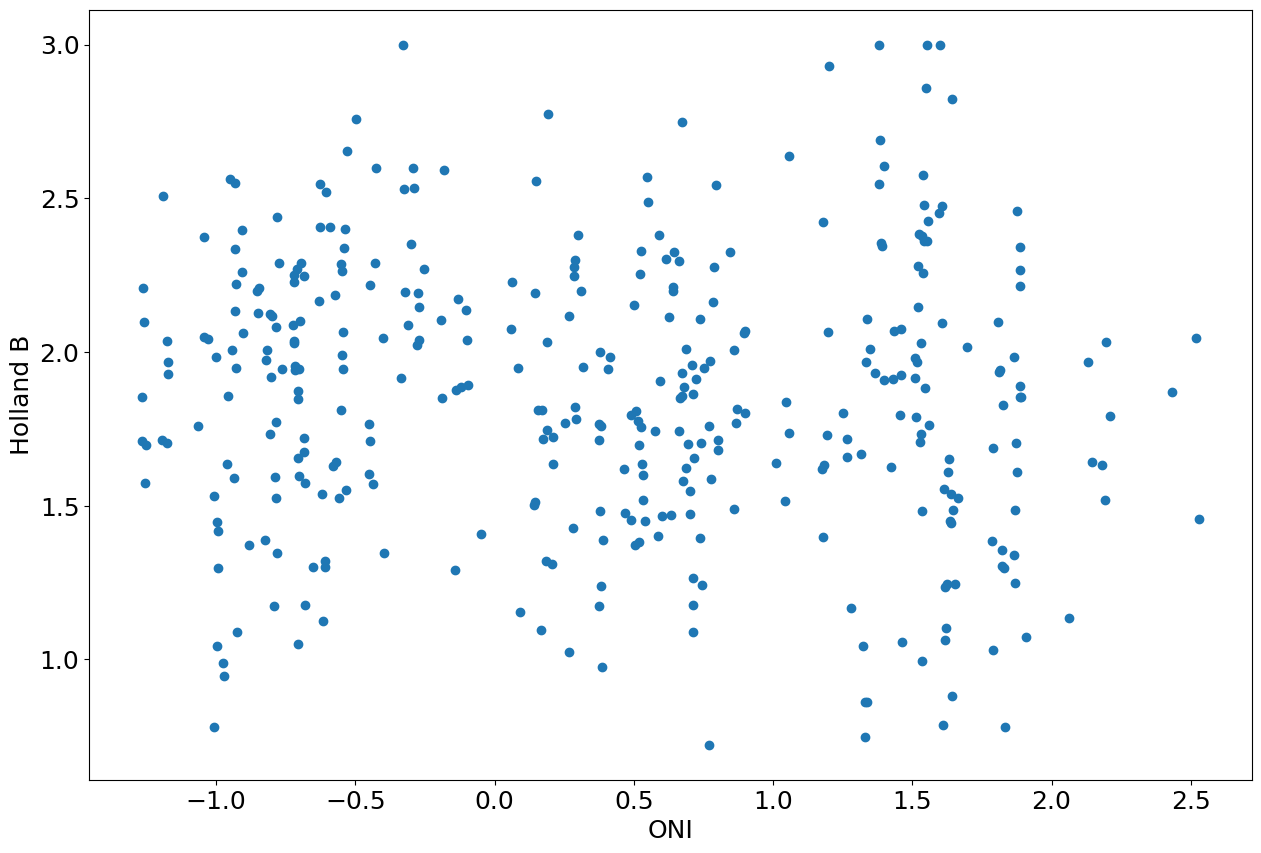

In [54]:
plt.scatter(d.oni_psl, d.B_hol)
plt.xlabel('ONI')
plt.ylabel('Holland B')

Text(0, 0.5, 'R34')

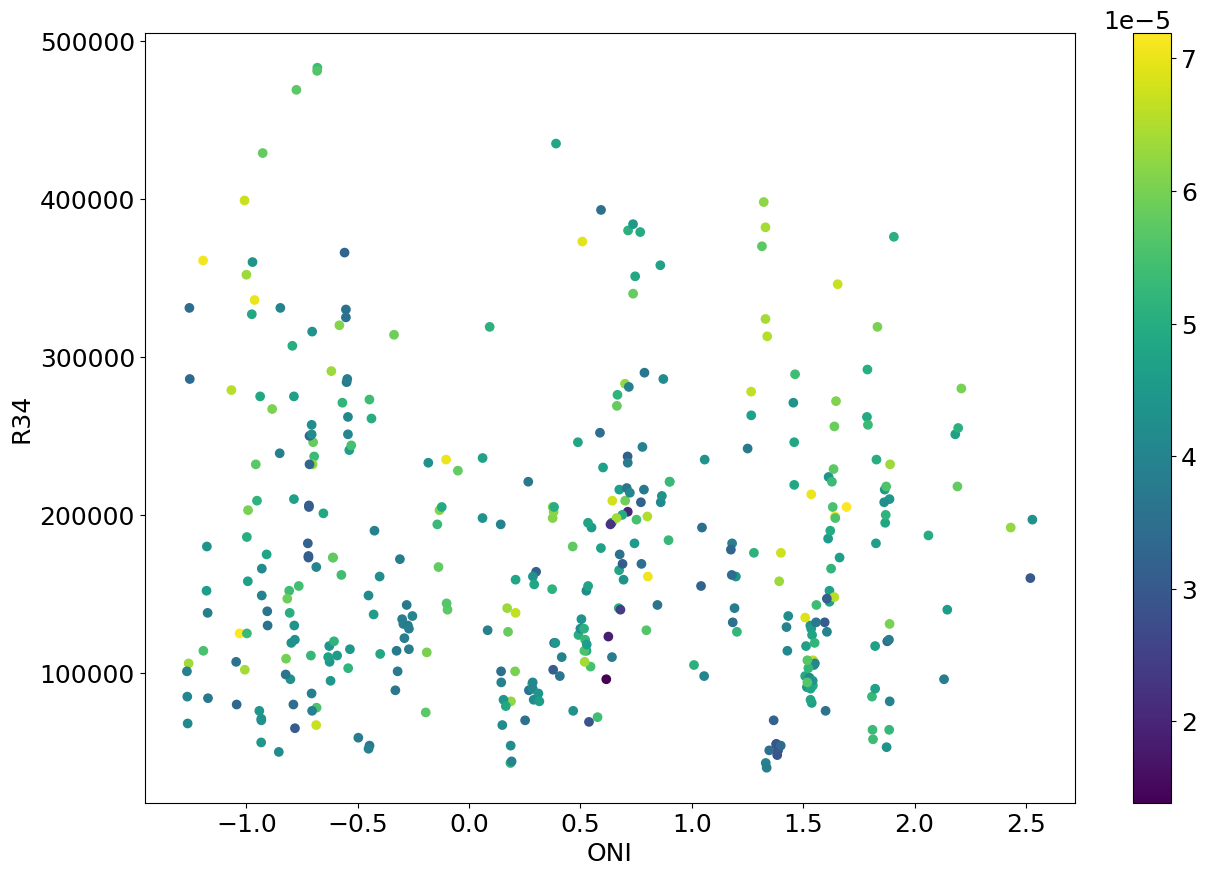

In [55]:
plt.scatter(d.oni_psl, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('ONI')
plt.ylabel('R34')

Text(0, 0.5, 'R34')

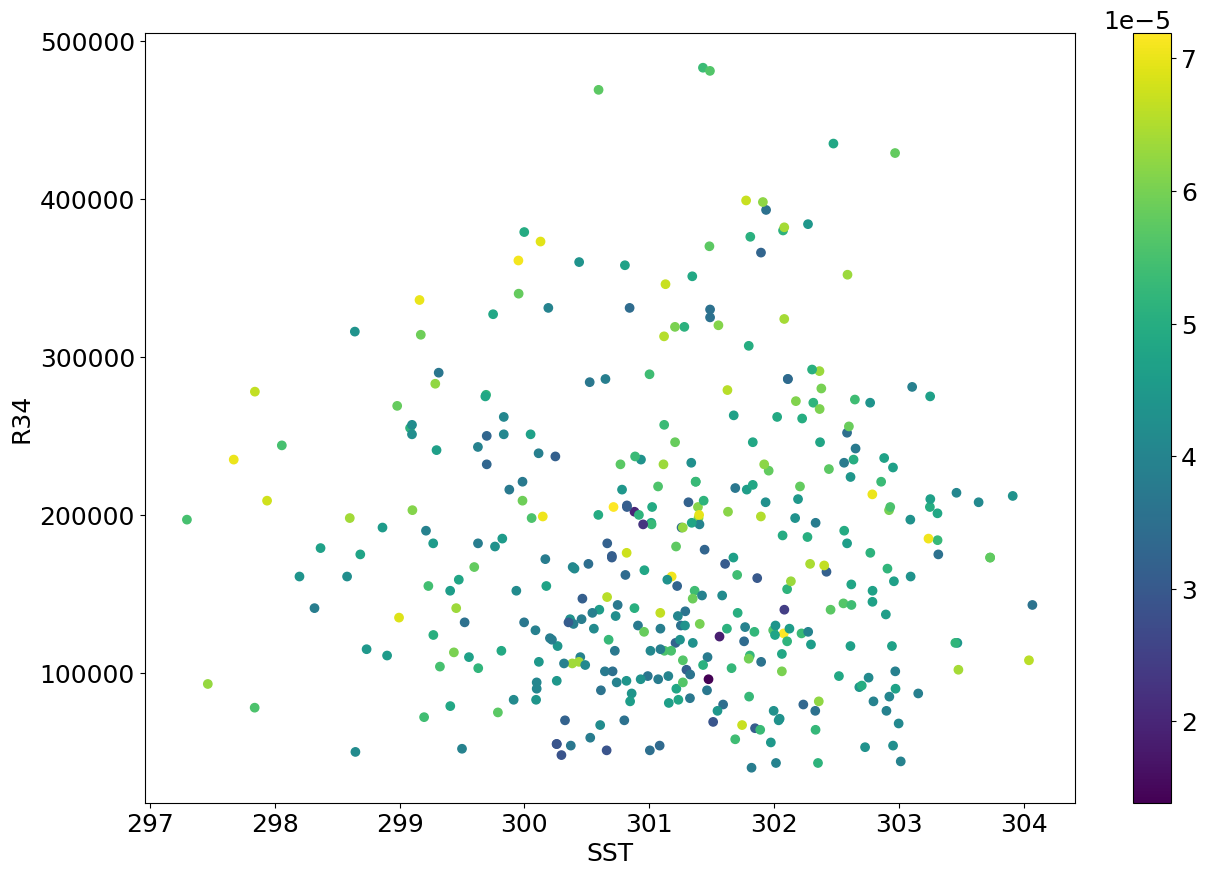

In [56]:
plt.scatter(d.sst_rms, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('SST')
plt.ylabel('R34')

(array([10., 28., 44., 34., 13., 12., 12., 10.,  6.,  2.]),
 array([0.0158931 , 0.0220098 , 0.02812649, 0.03424319, 0.04035988,
        0.04647658, 0.05259327, 0.05870997, 0.06482666, 0.07094336,
        0.07706005]),
 <BarContainer object of 10 artists>)

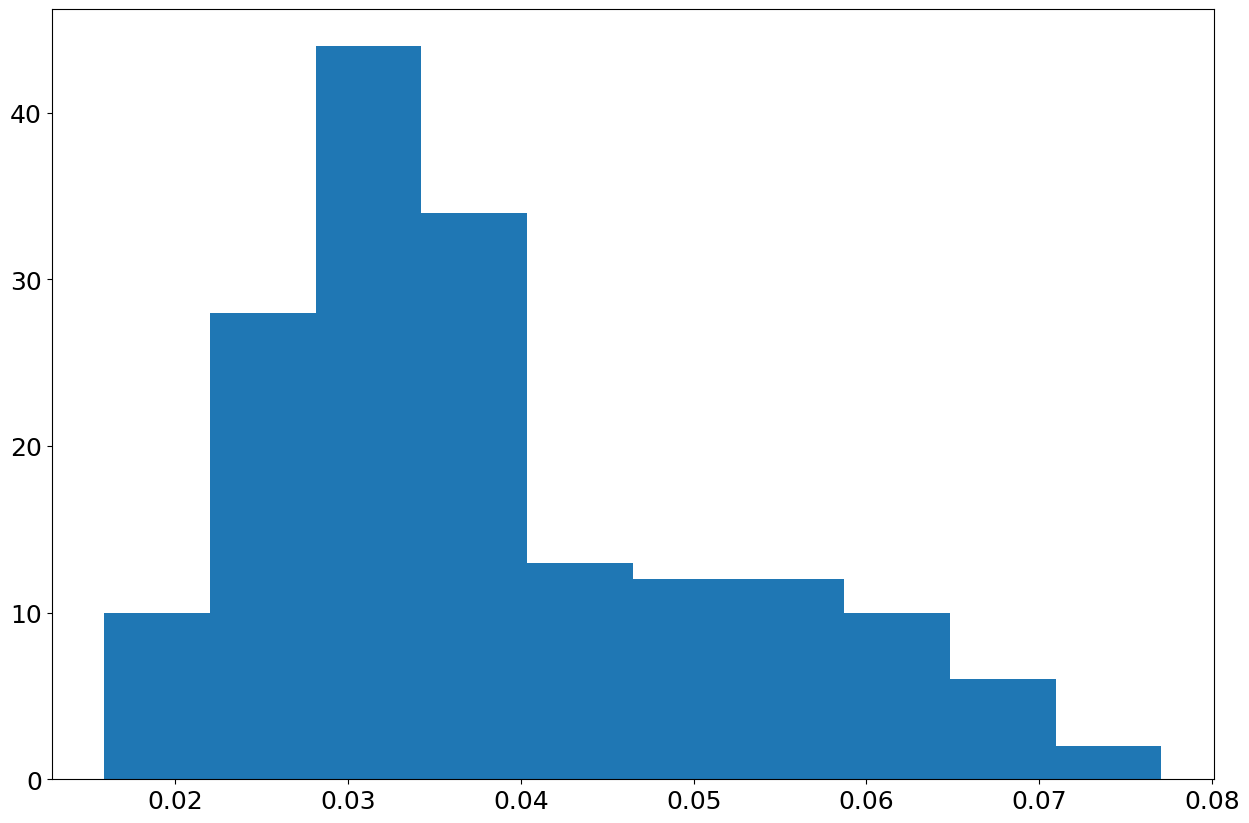

In [57]:
plt.hist(d.beta0 / 15000)

### 2) Variation by basin

/tmp/ipykernel_13626/3892731901.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


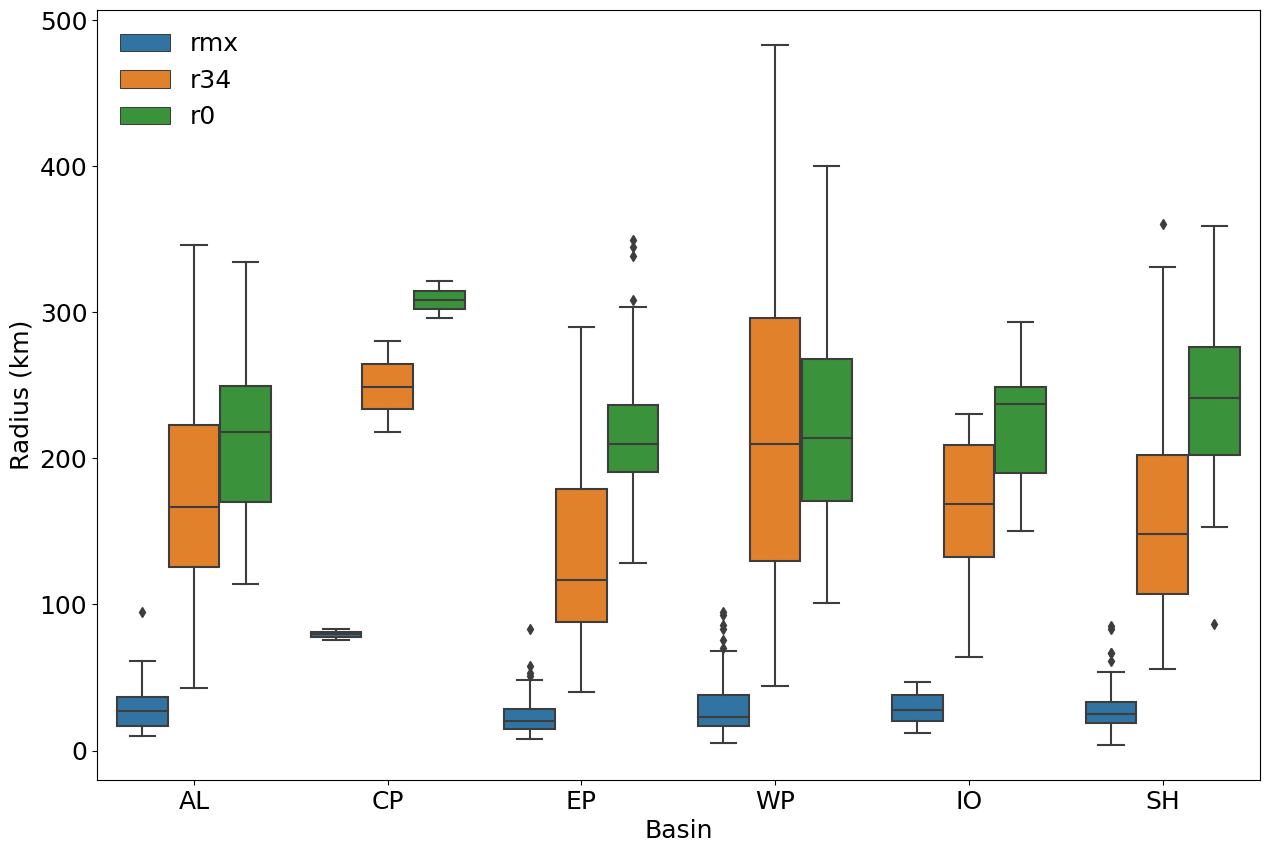

In [58]:
df      = d[['basin_idx', 'rmx', 'r34', 'r0']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rmx', 'r34', 'r0'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks() / 1000]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Radius (km)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

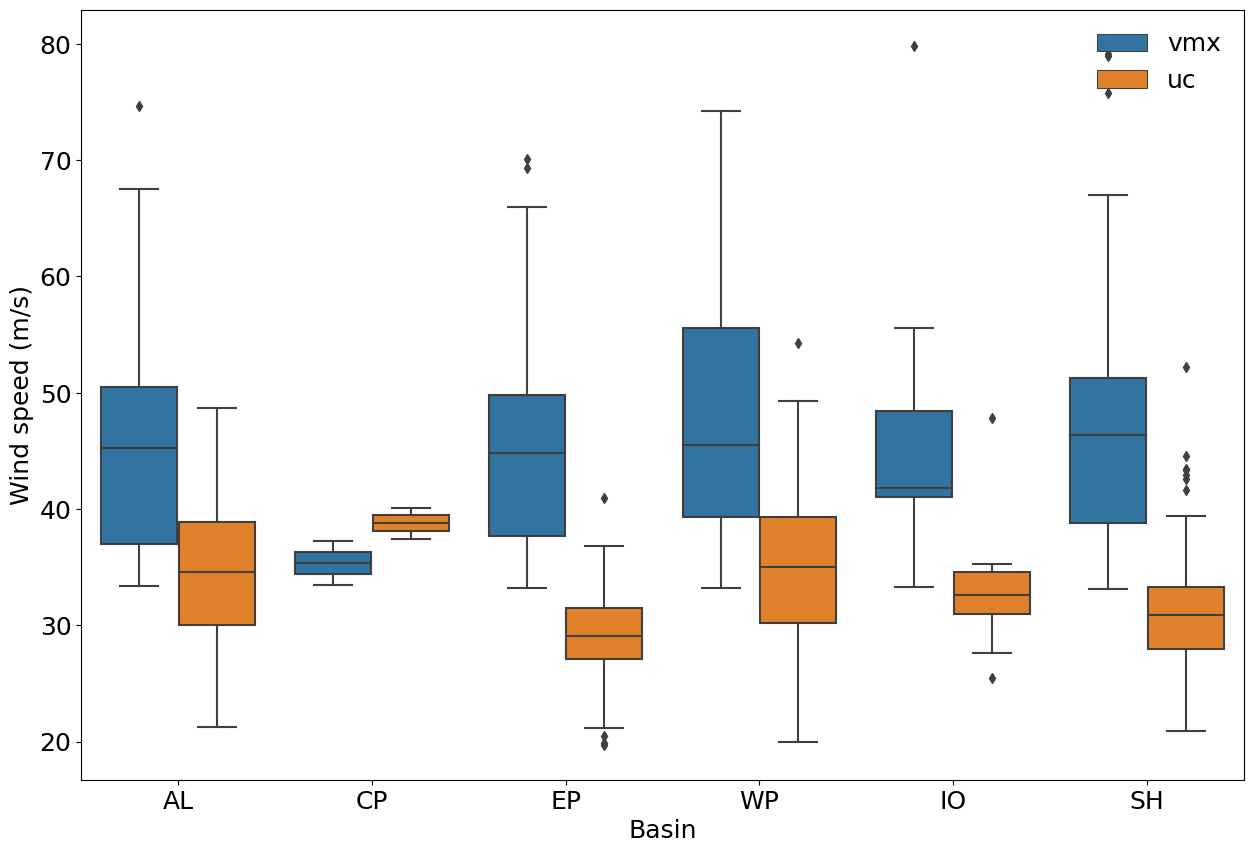

In [59]:
df      = d[['basin_idx', 'vmx', 'uc']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmx', 'uc'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Wind speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

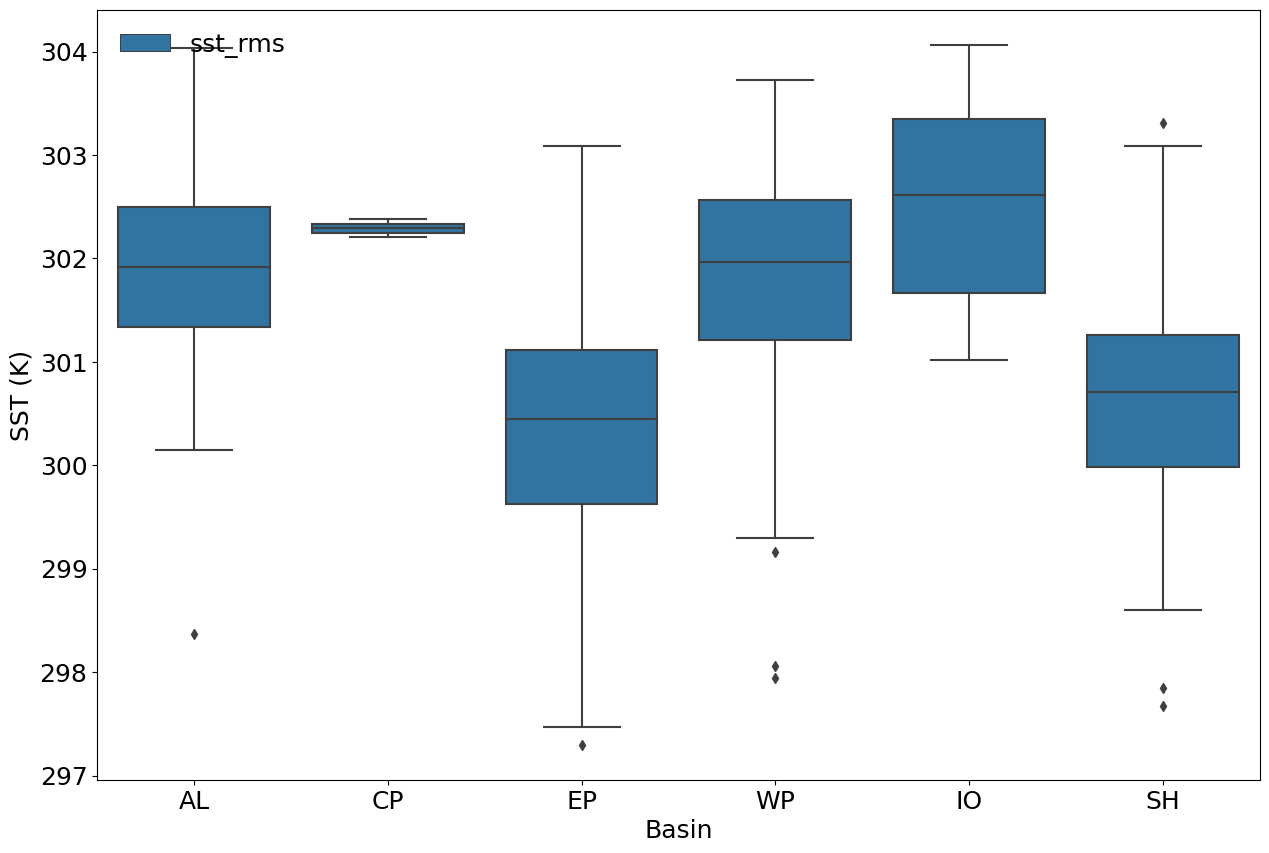

In [60]:
df      = d[['basin_idx', 'sst_rms']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['sst_rms'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('SST (K)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

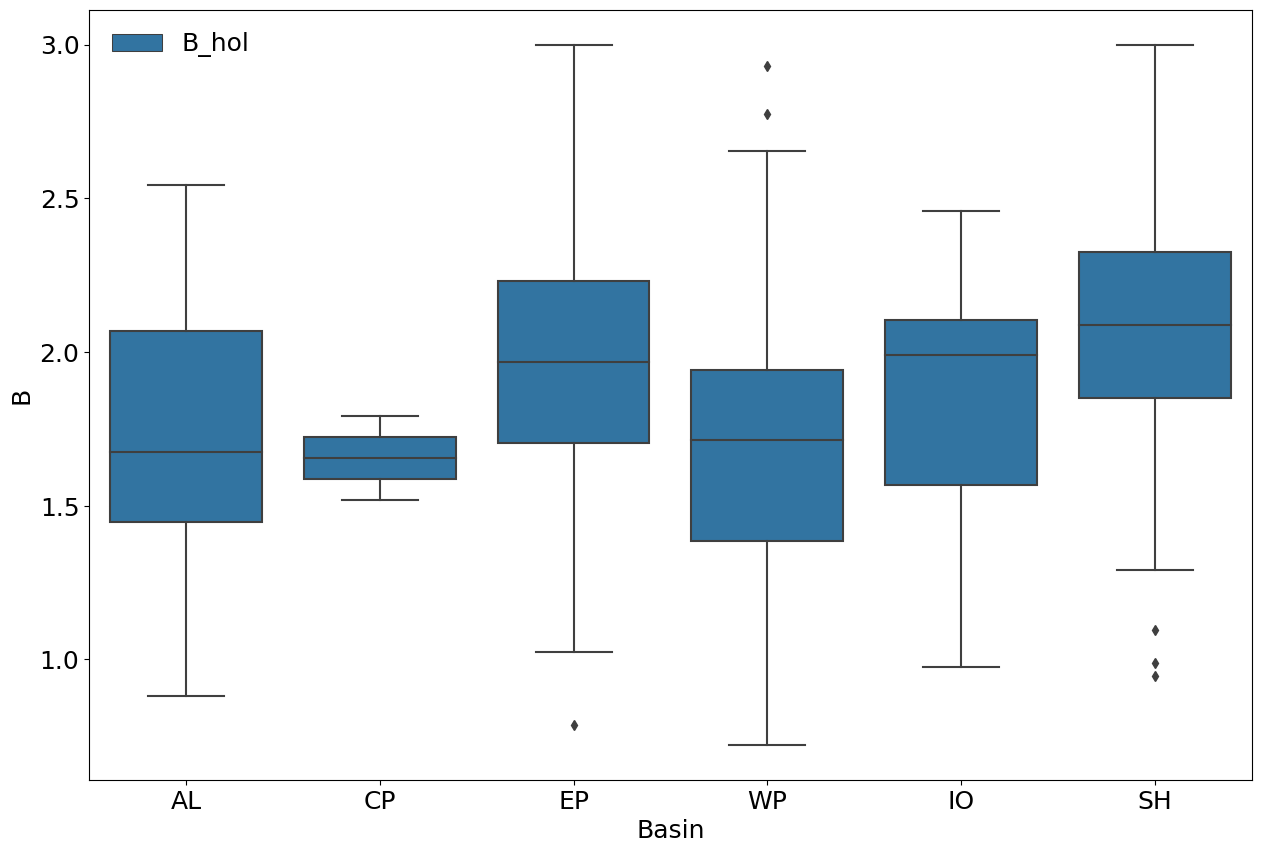

In [61]:
df      = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['B_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('B')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

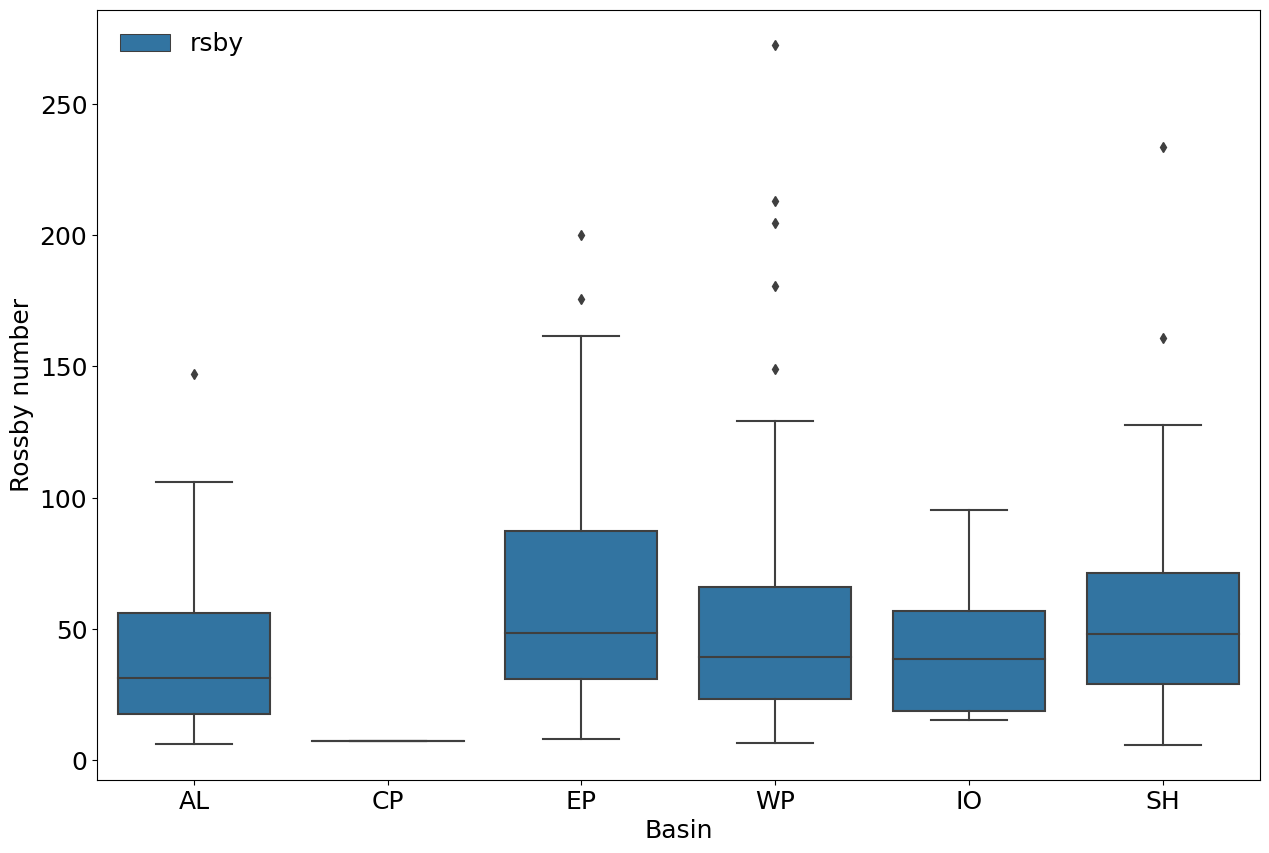

In [62]:
df      = d[['basin_idx', 'rsby']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rsby'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Rossby number')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

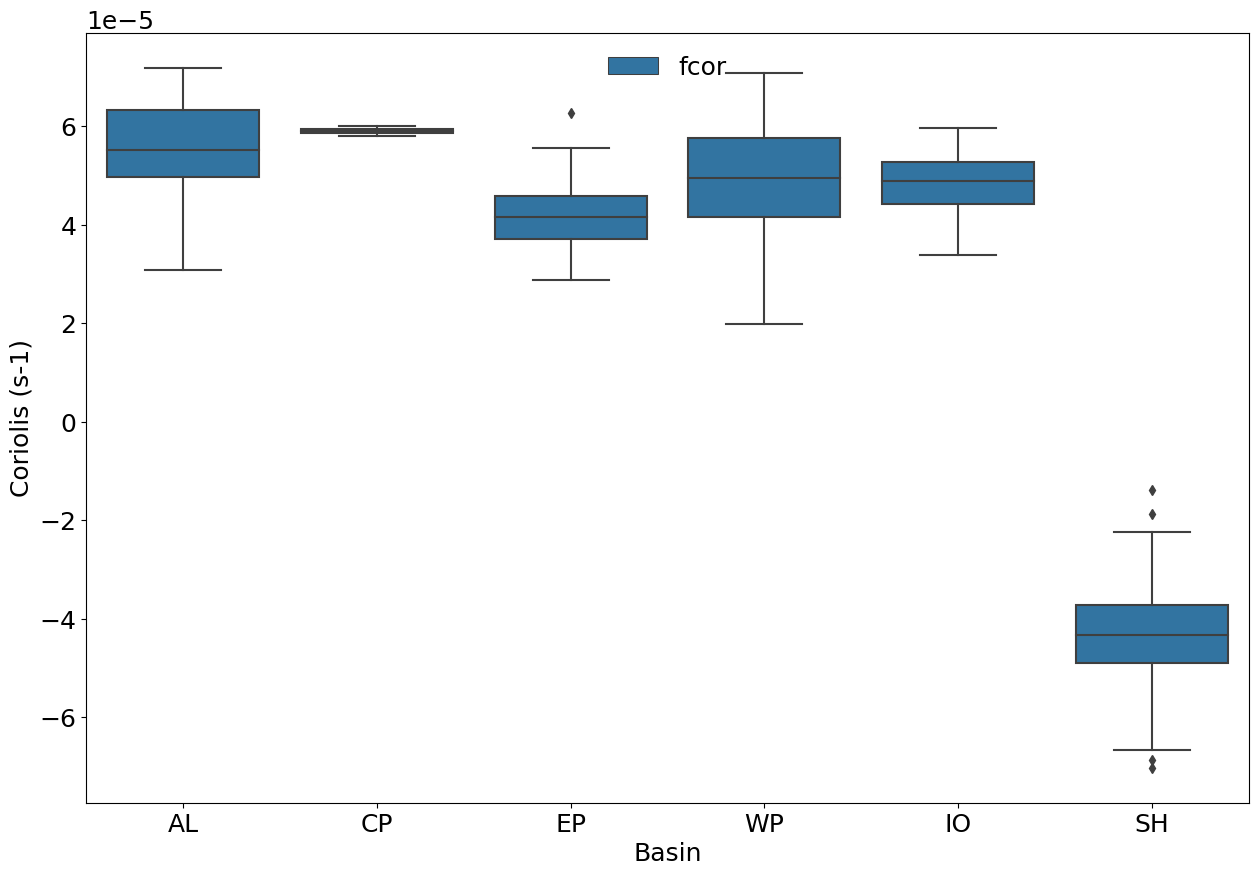

In [63]:
df      = d[['basin_idx', 'fcor']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['fcor'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Coriolis (s-1)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

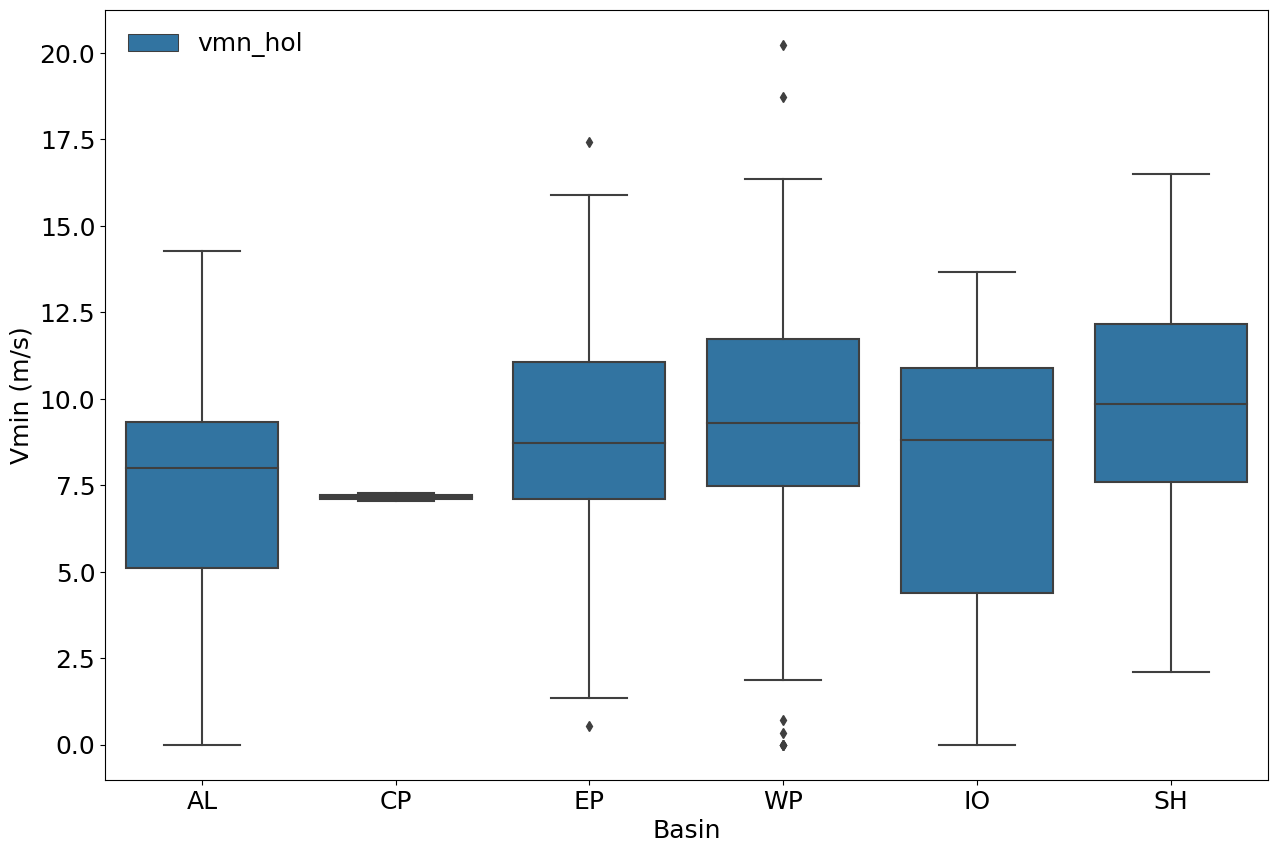

In [64]:
df      = d[['basin_idx', 'vmn_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmn_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Vmin (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

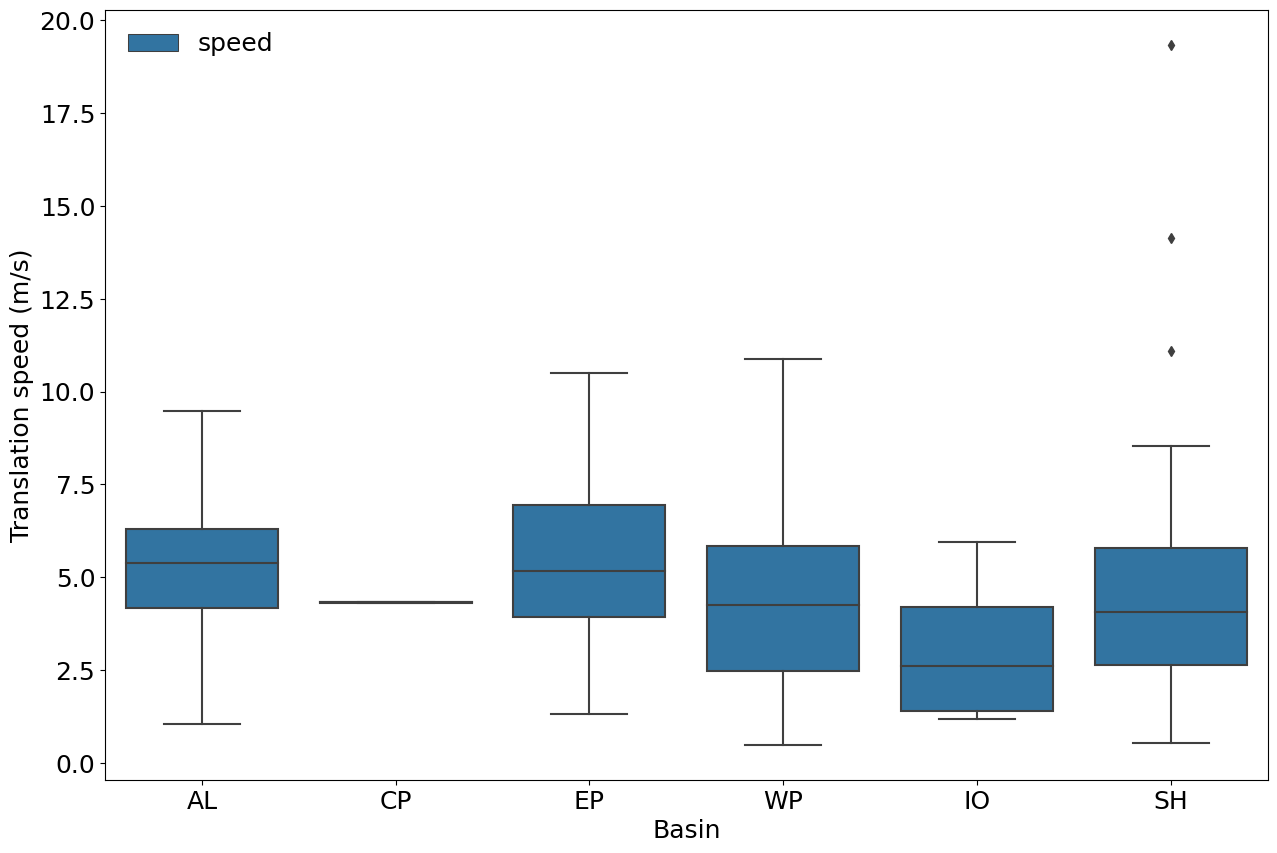

In [65]:
df      = d[['basin_idx', 'speed']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['speed'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Translation speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

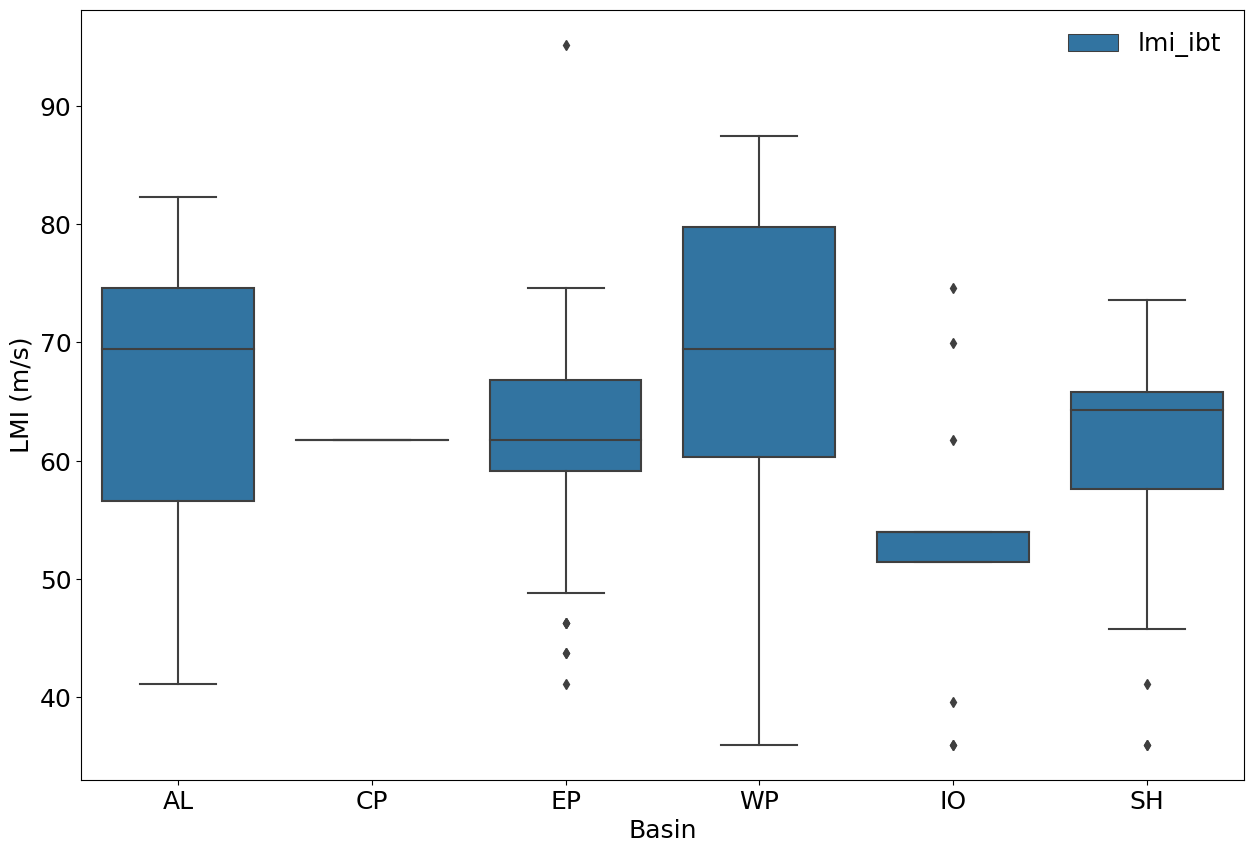

In [66]:
df      = d[['basin_idx', 'lmi_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['lmi_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('LMI (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

/tmp/ipykernel_13626/2202944619.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


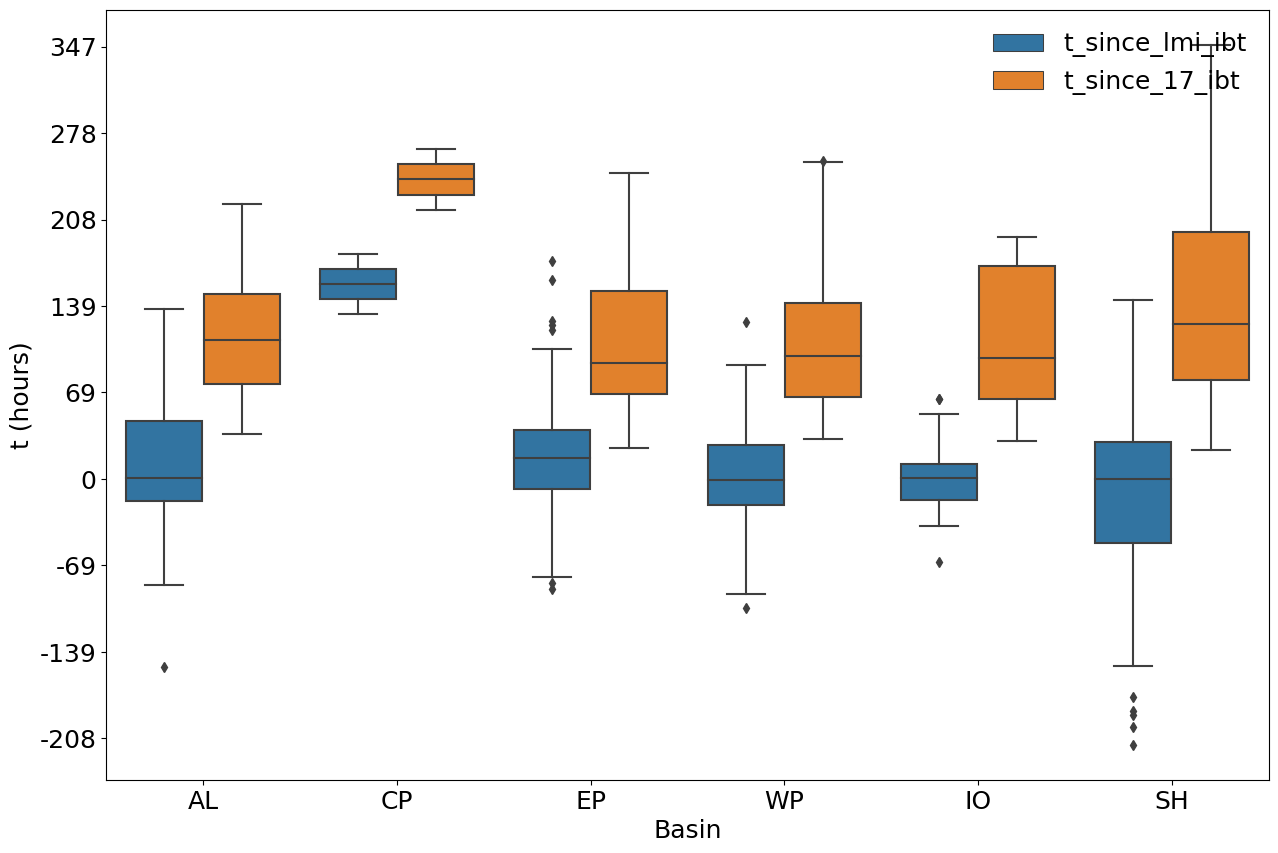

In [67]:
df      = d[['basin_idx', 't_since_lmi_ibt', 't_since_17_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['t_since_lmi_ibt', 't_since_17_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y / 3600) for y in g.get_yticks()]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('t (hours)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

### 3) Dependance by basin

In [68]:
da = d.where(d.basin == 'al', drop=True)
dc = d.where(d.basin == 'cp', drop=True)
de = d.where(d.basin == 'ep', drop=True)
di = d.where(d.basin == 'io', drop=True)
ds = d.where(d.basin == 'sh', drop=True)
dw = d.where(d.basin == 'wp', drop=True)

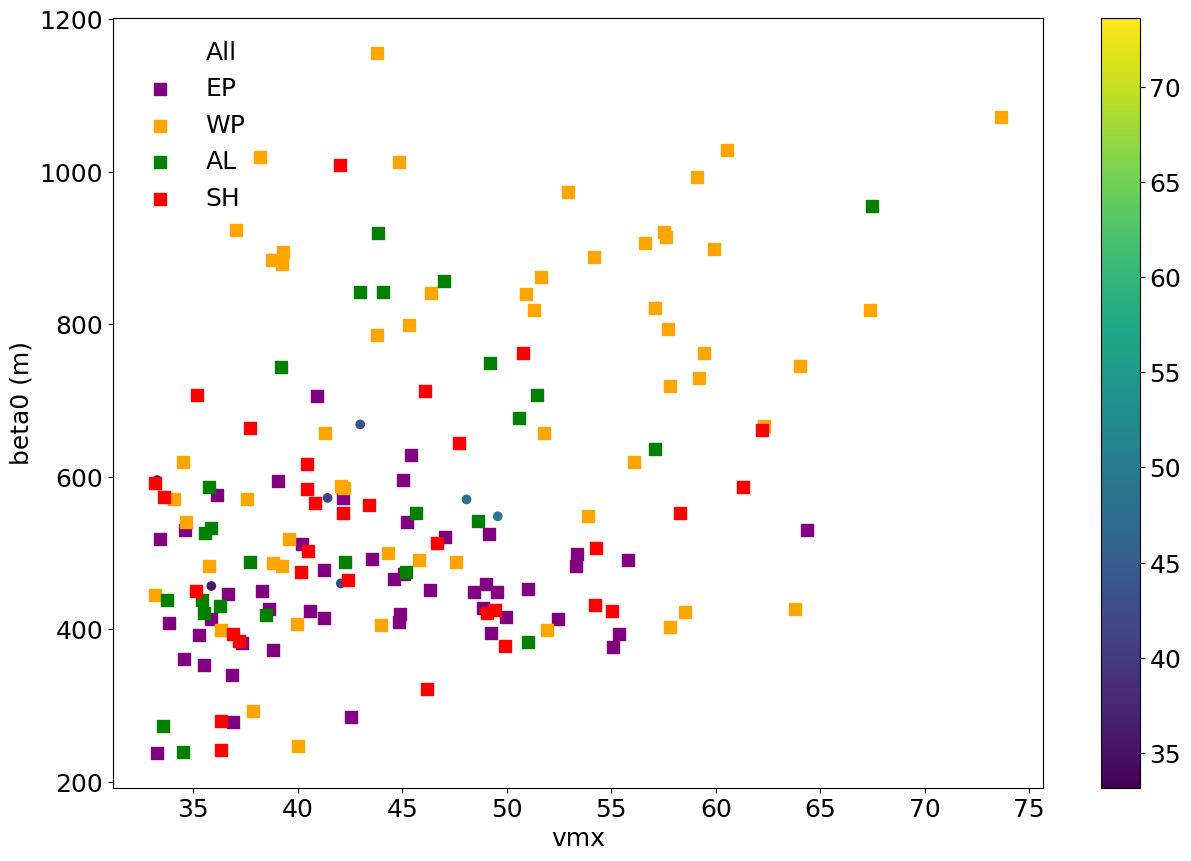

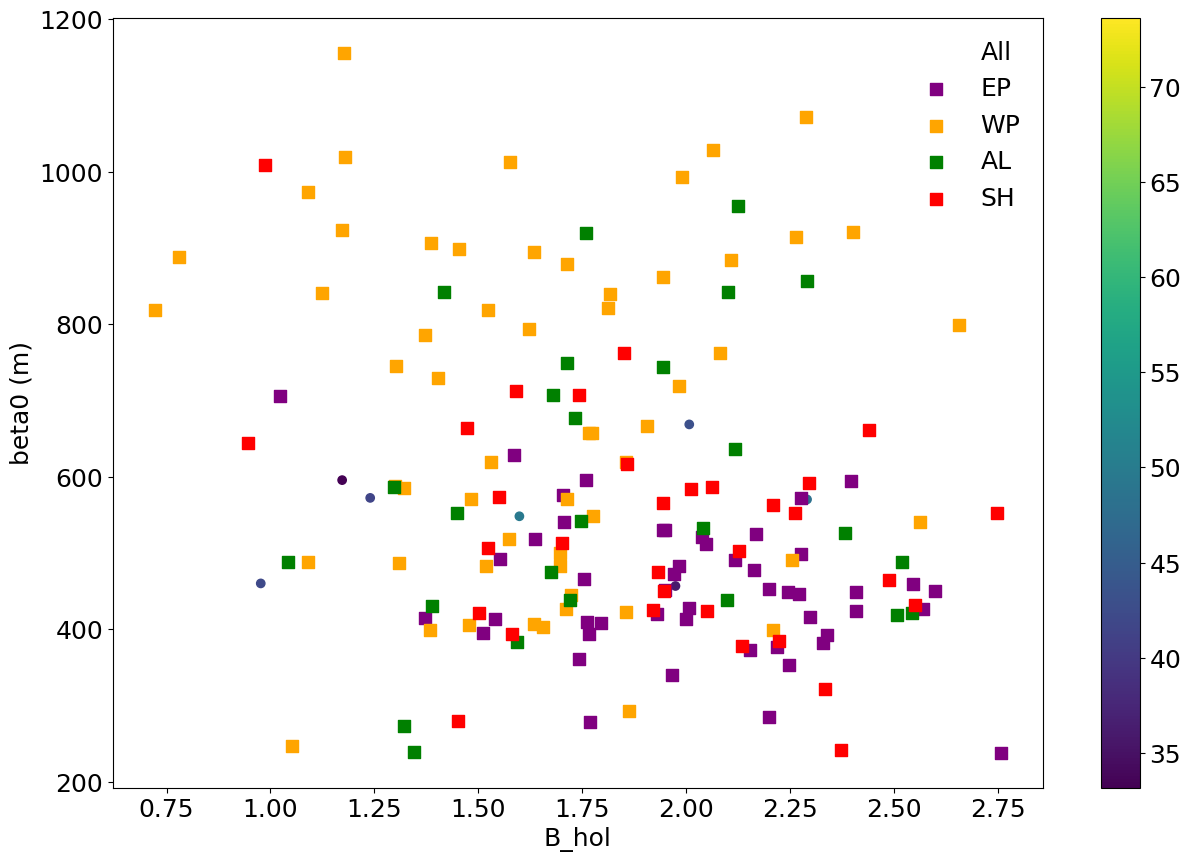

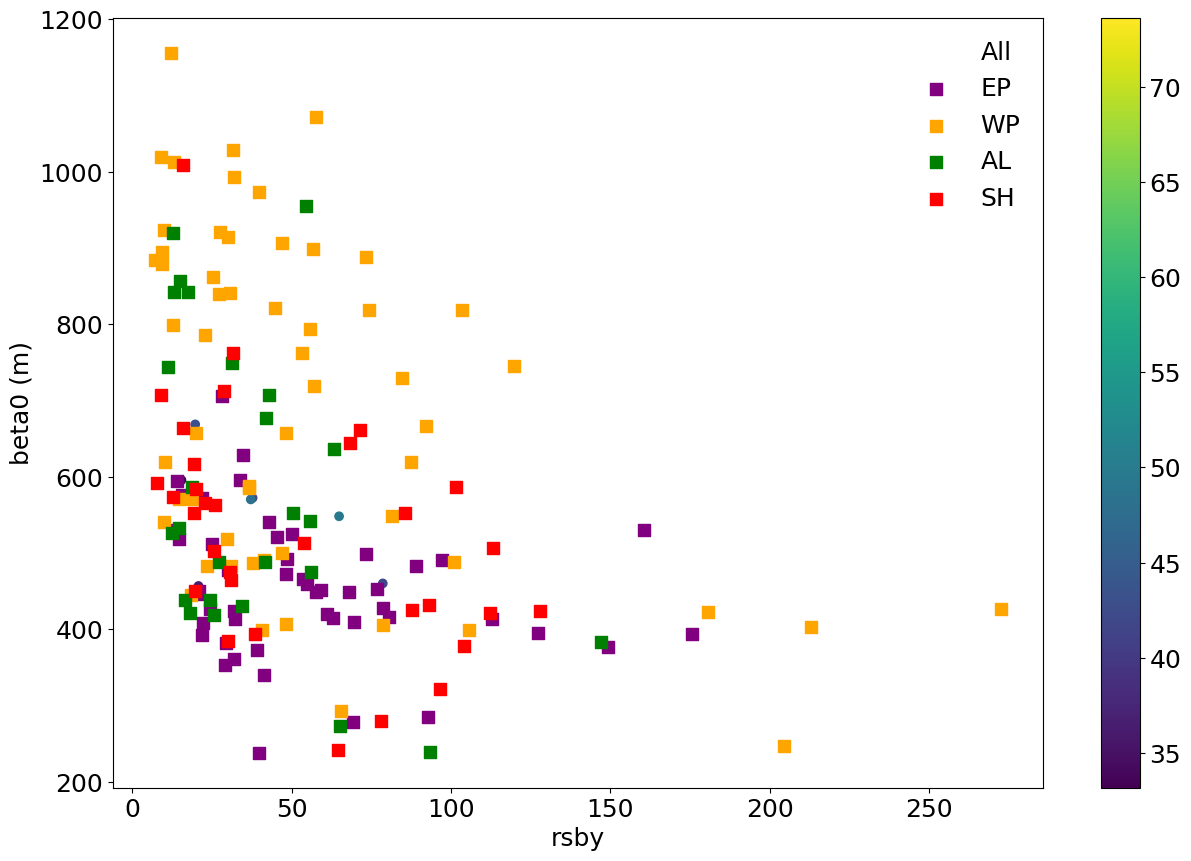

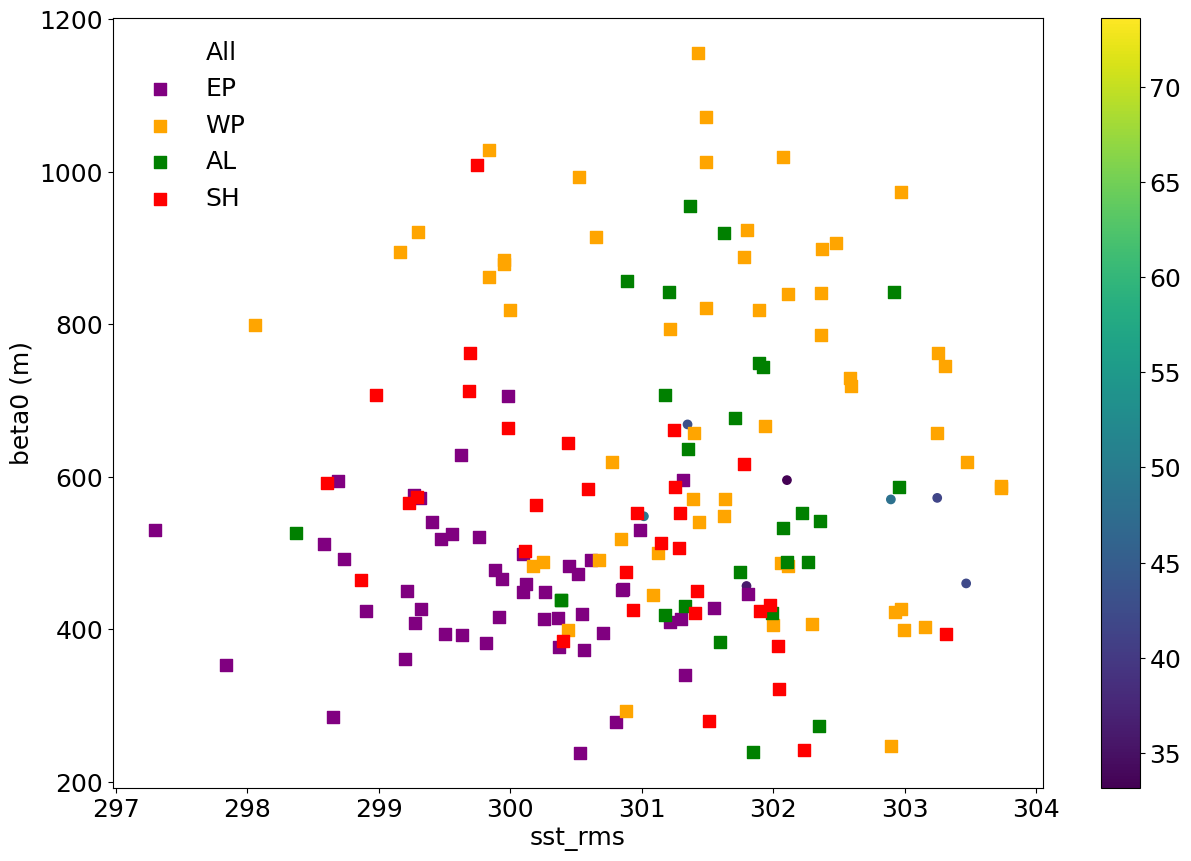

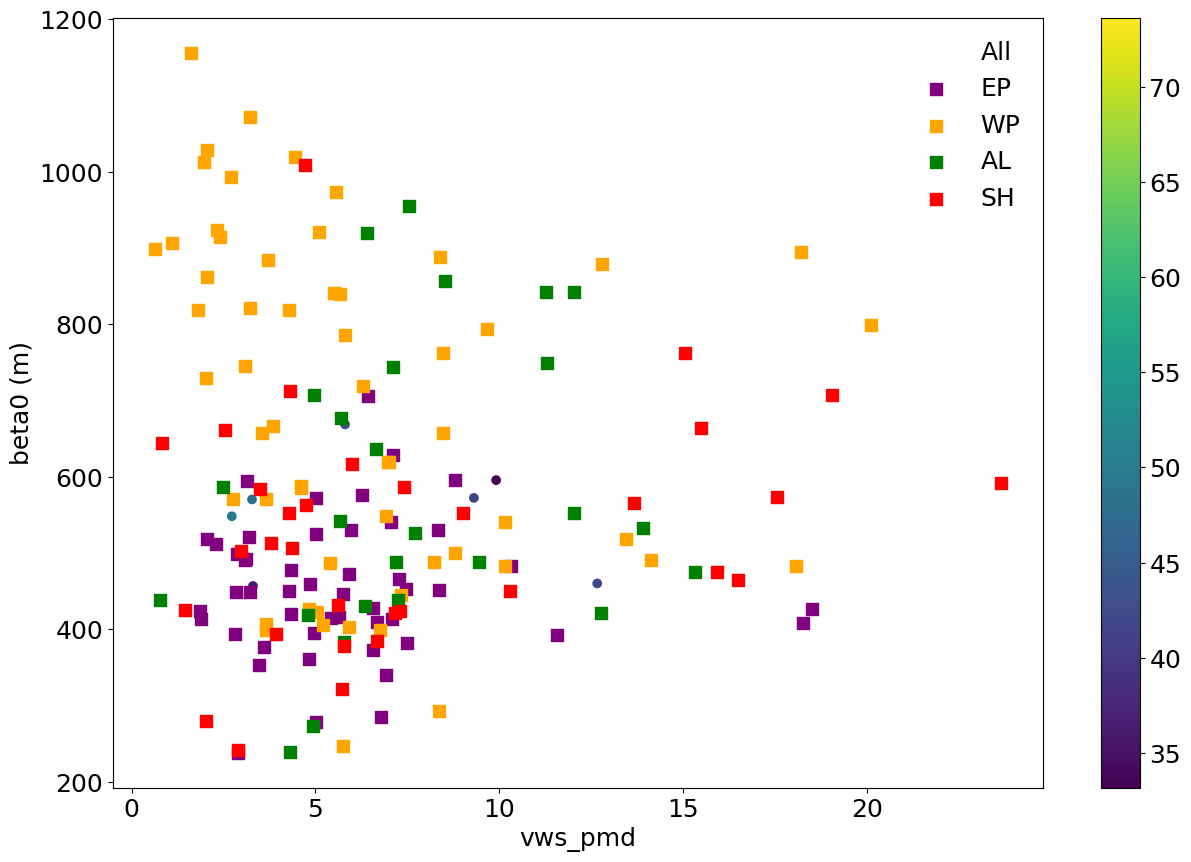

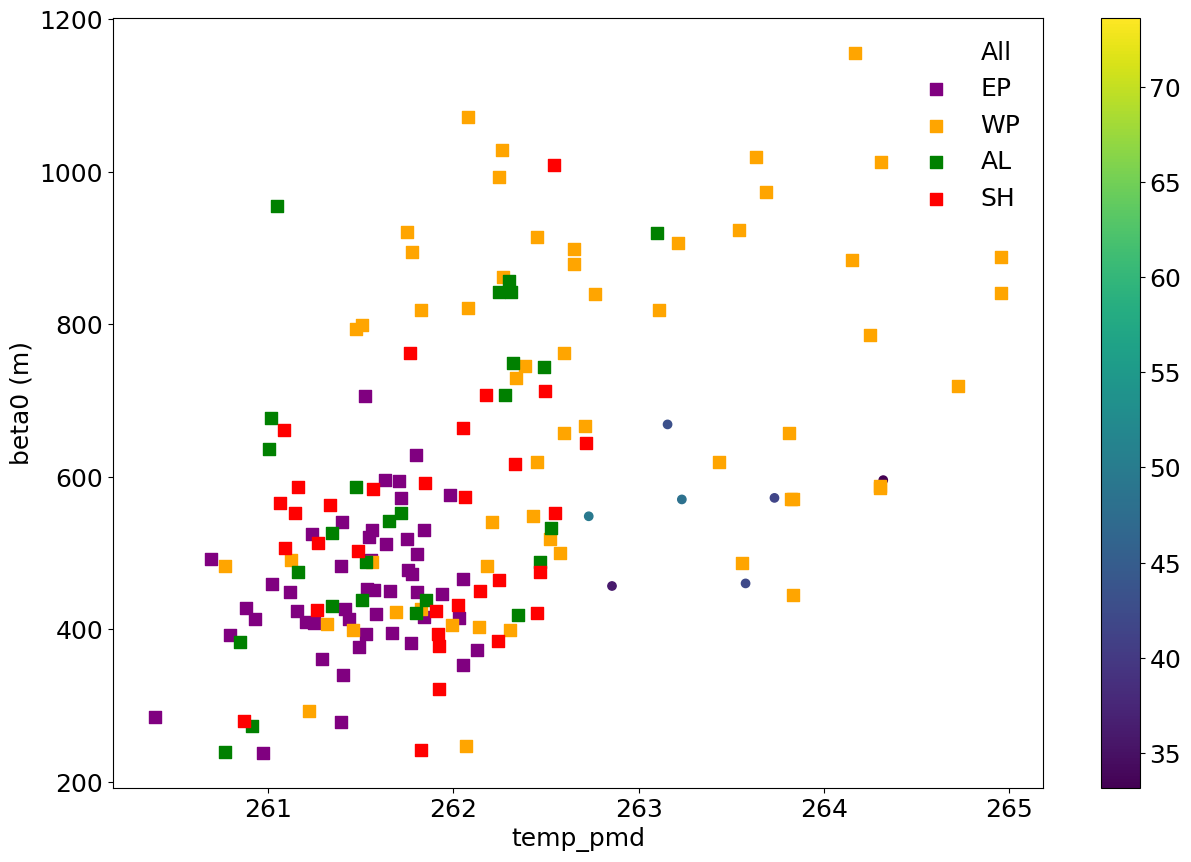

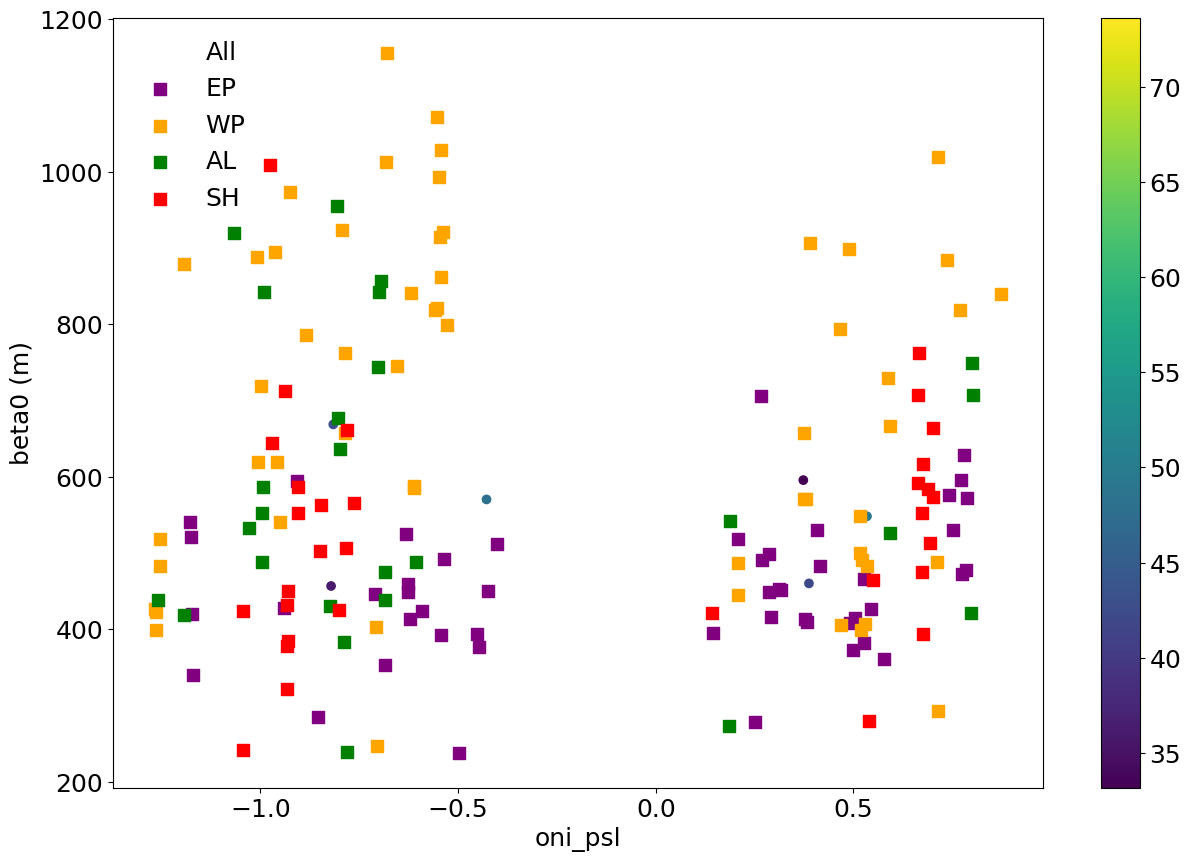

In [86]:
for prm in ['vmx', 'B_hol', 'rsby', 'sst_rms', 'vws_pmd', 'temp_pmd', 'oni_psl']:
    plt.scatter(d[prm],  d.beta0,  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de.beta0, c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw.beta0, c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da.beta0, c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds.beta0, c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('beta0 (m)')
    plt.show()

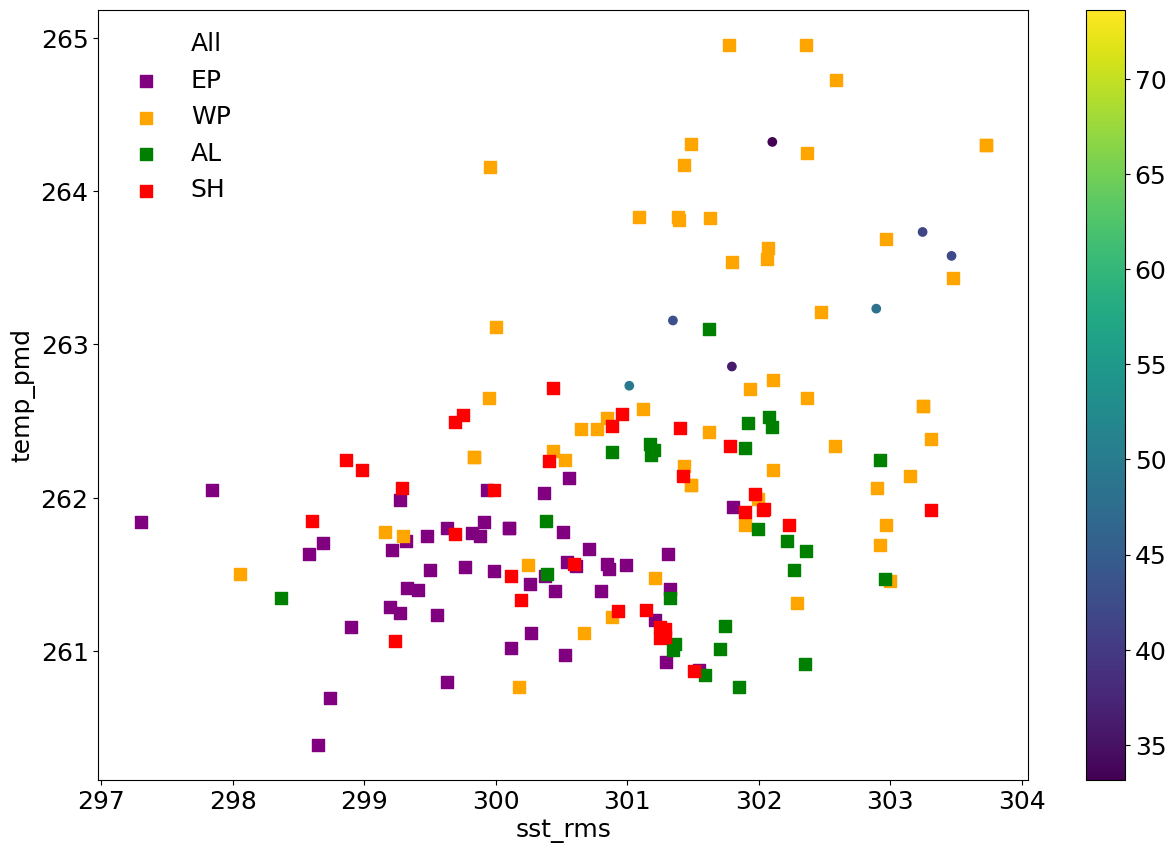

In [87]:
y = 'temp_pmd'

for prm in ['sst_rms']:
    plt.scatter(d[prm],  d[y],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel(y)
    plt.show()

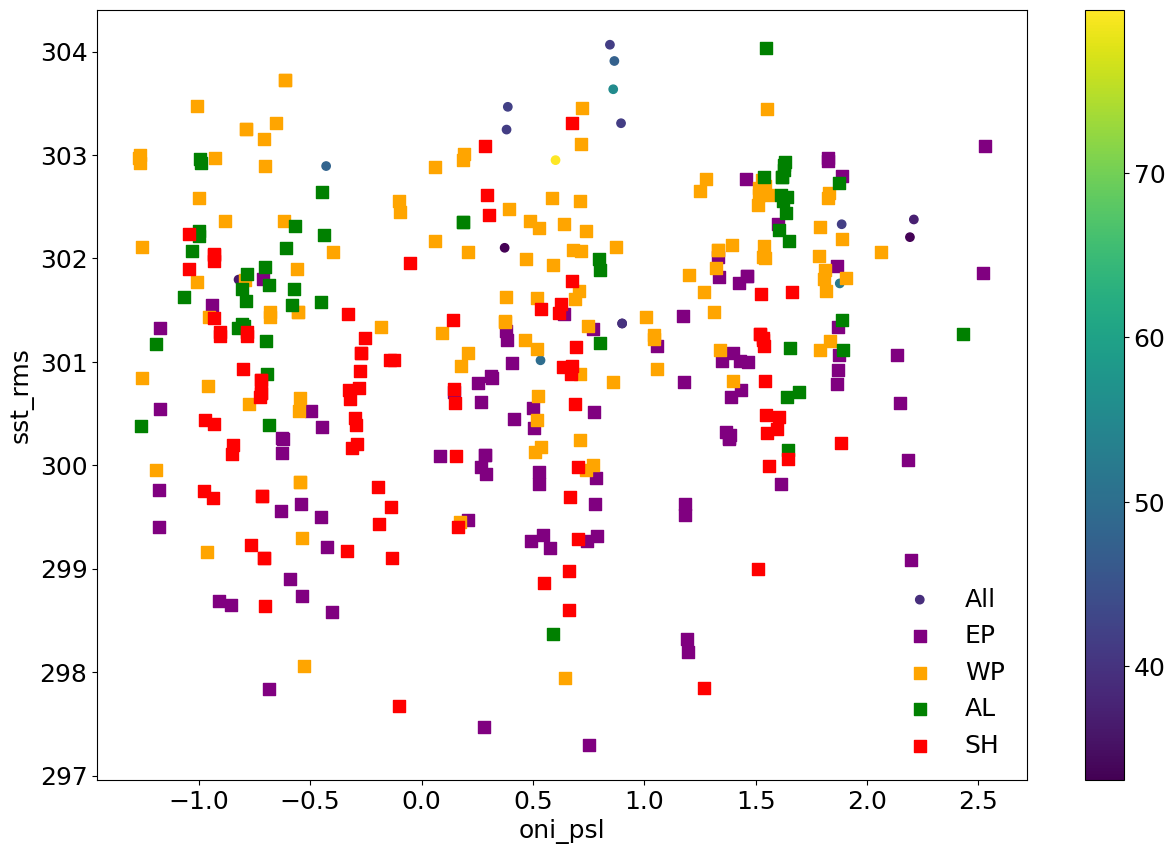

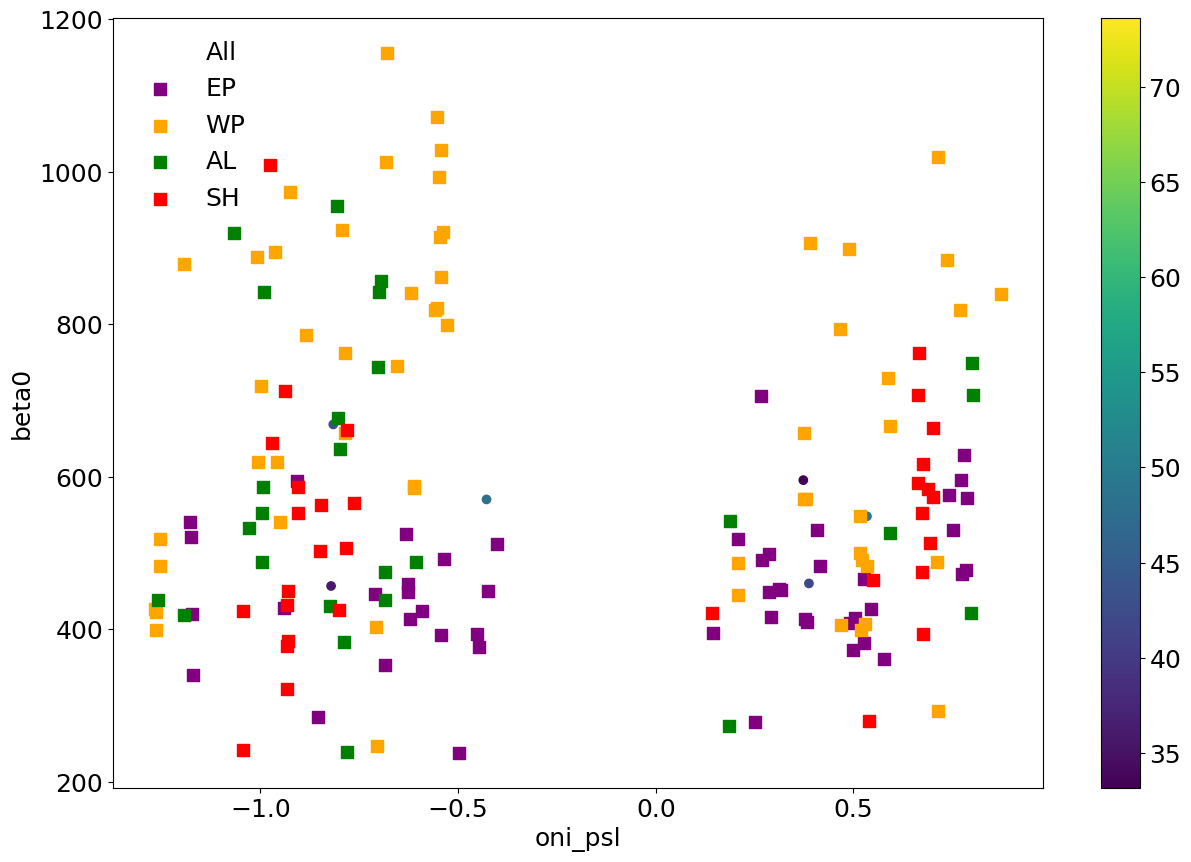

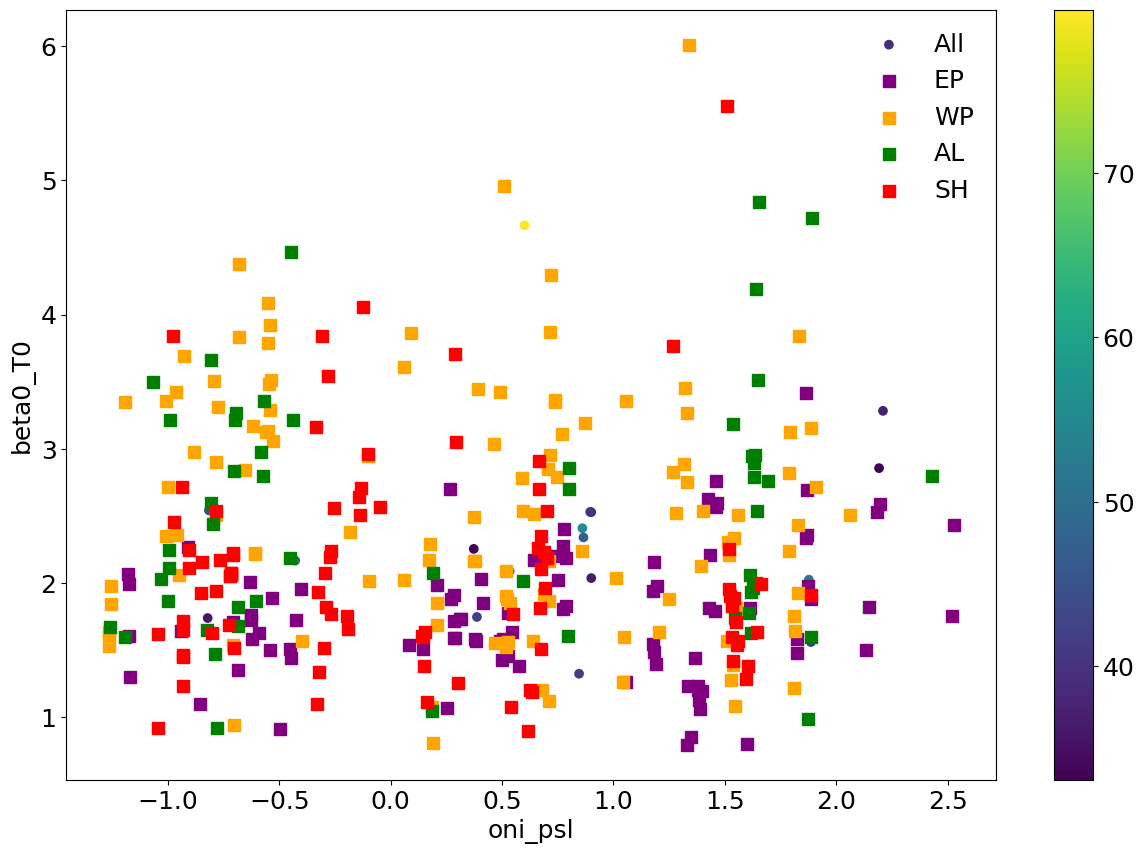

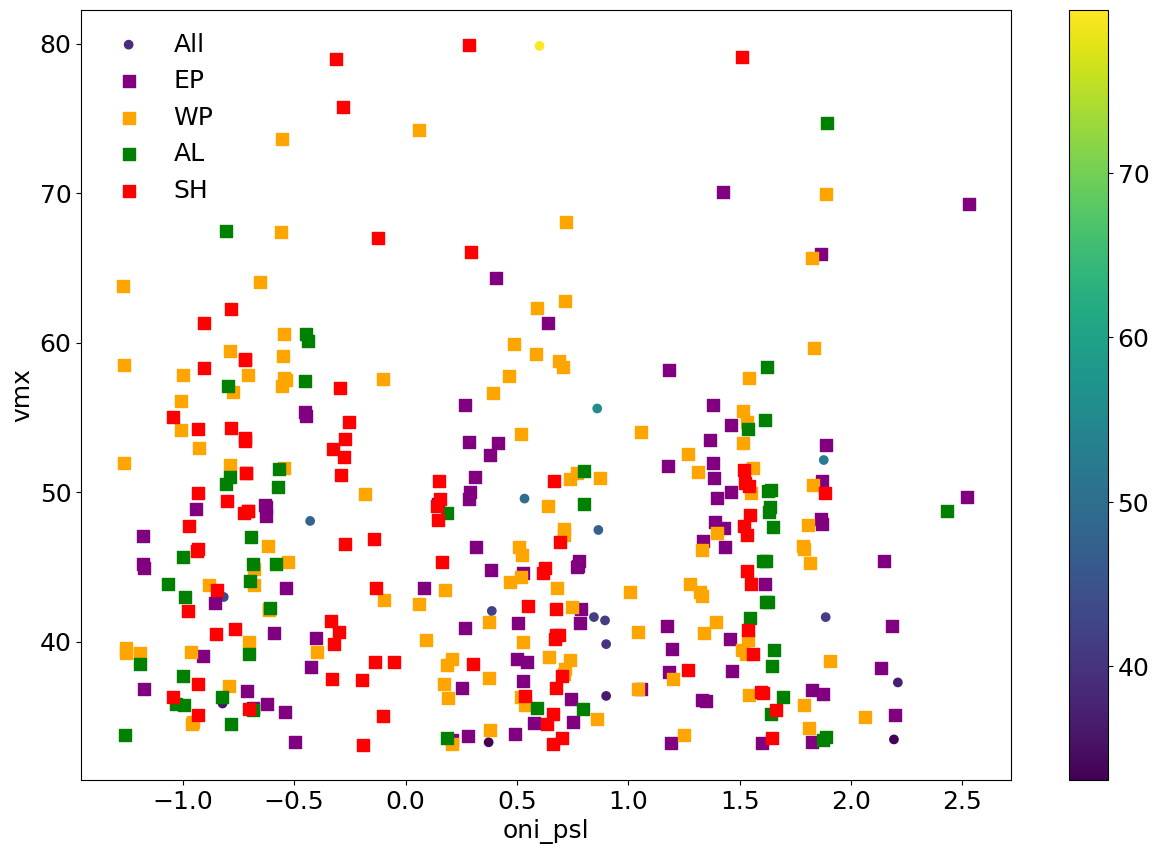

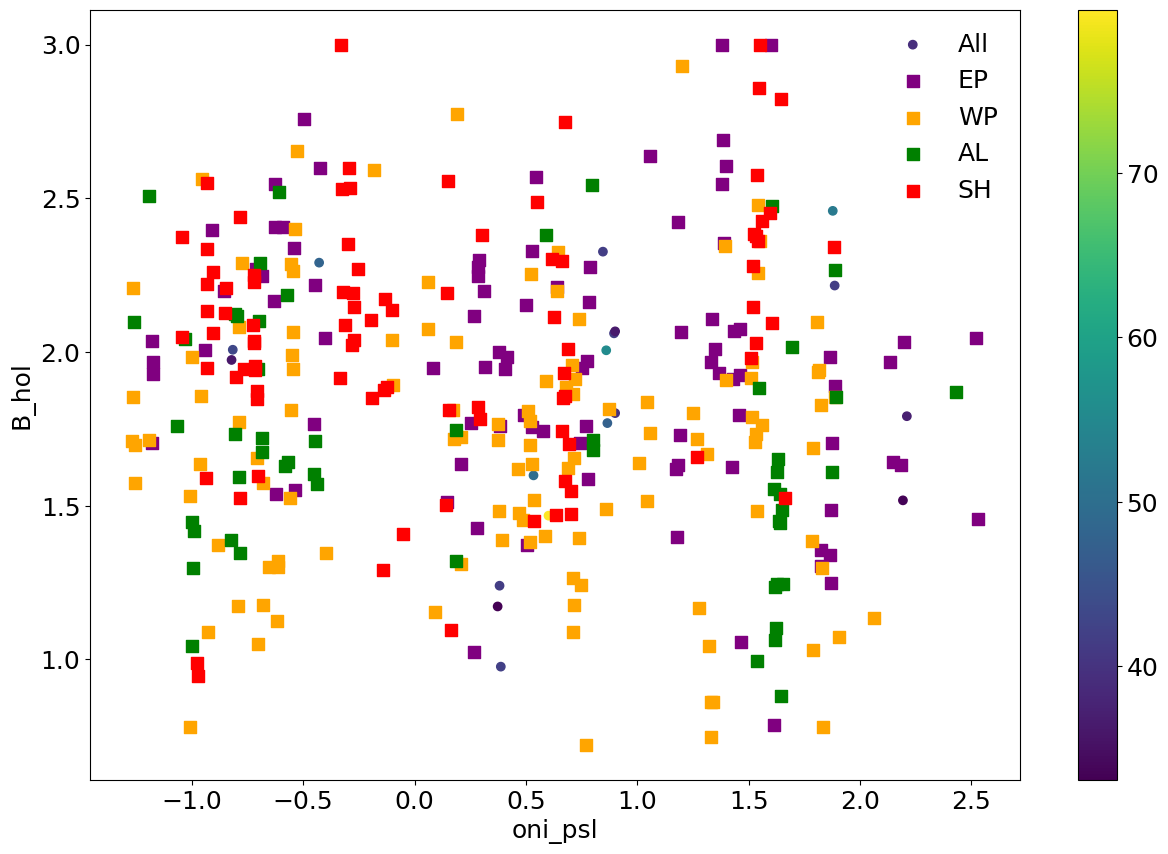

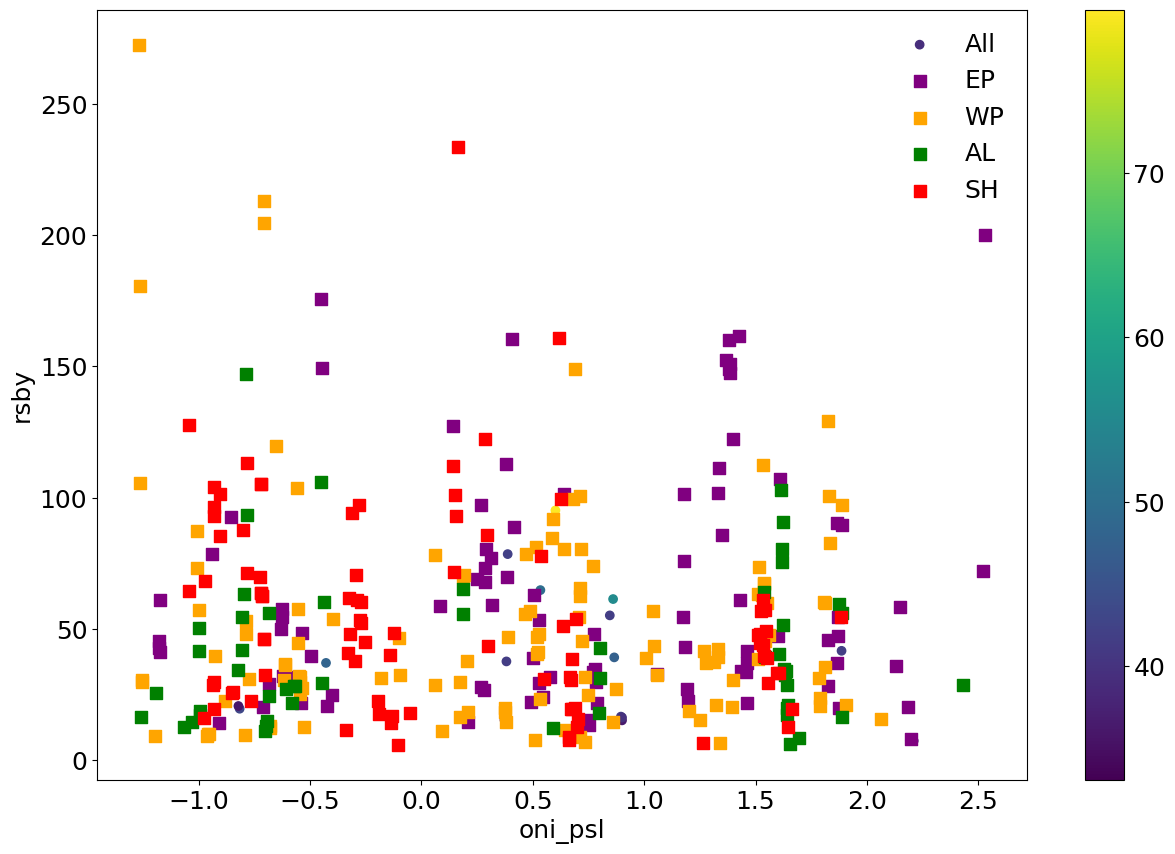

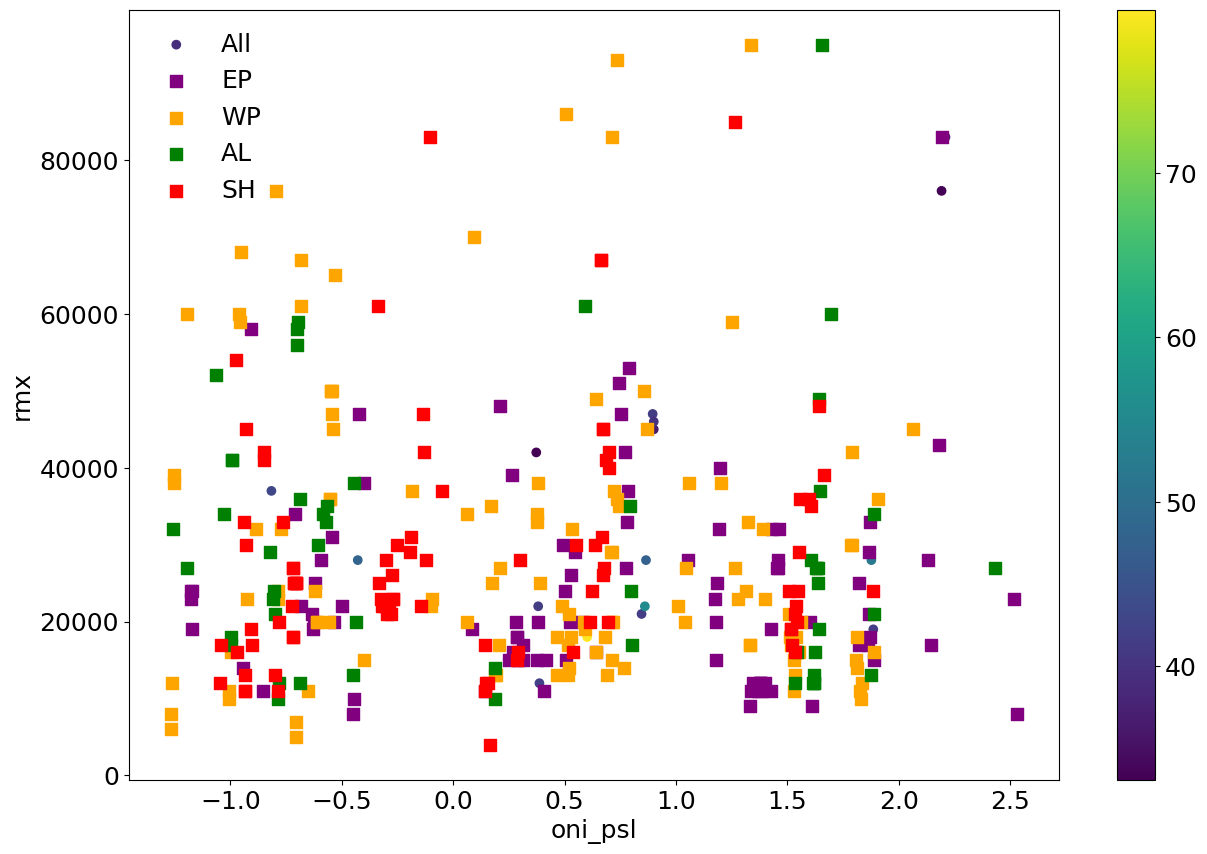

In [88]:
x = 'oni_psl'

for prm in ['sst_rms', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(d[x],  d[prm],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[x], de[prm], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[x], dw[prm], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[x], da[prm], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[x], ds[prm], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

### 4) Conditional dependance

In [72]:
# plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.uc ** 2, cmap=cm.get_cmap('Reds'))
# # plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.oni_psl)
# plt.colorbar()

In [73]:
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.uc ** 2)
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.sst_rms)
# plt.colorbar()

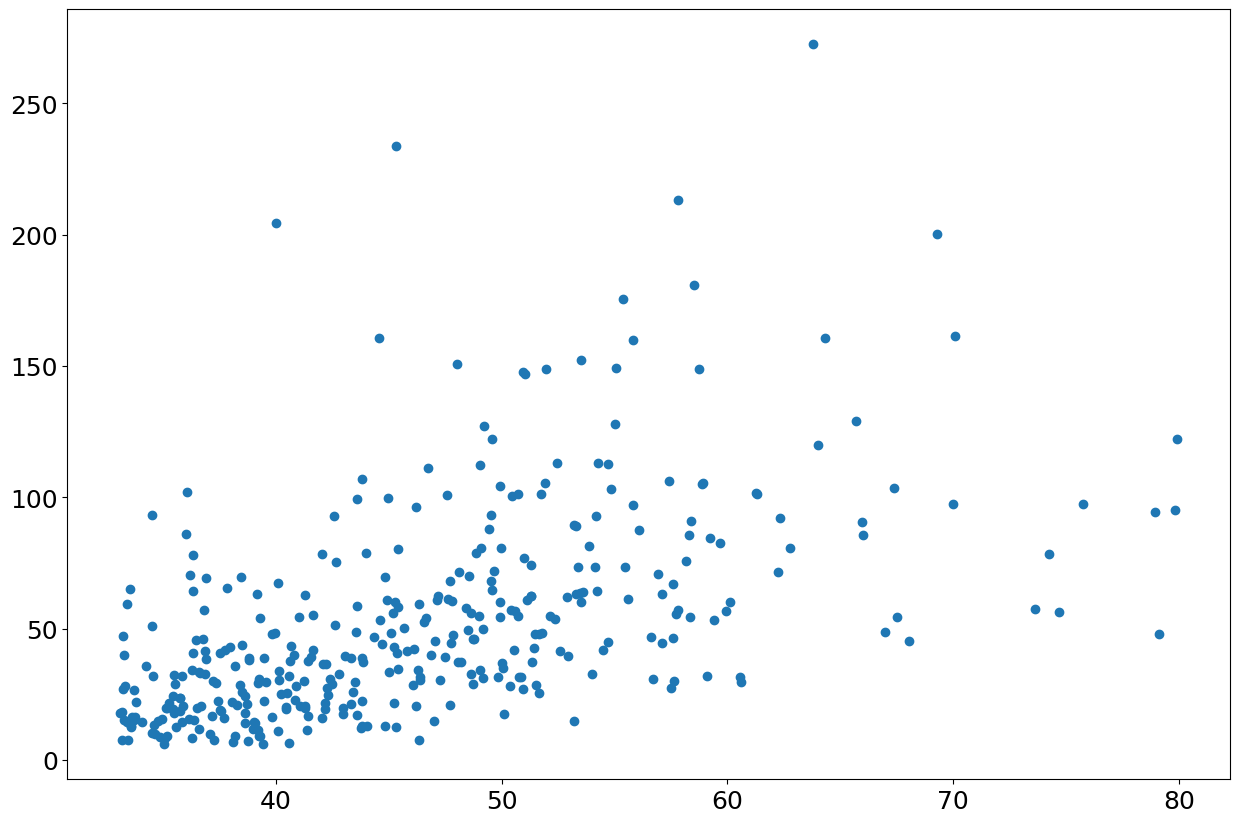

In [74]:
plt.scatter(d.vmx, d.rsby)

In [75]:
# Also try Vmax  55 m/s
cond = (d.vmx > 55) & (d.vmx < 57) & (d.rsby > 80) & (d.rsby < 100)
dcd  = d.where(cond, drop=True)

In [76]:
print('Vmax ** 2 variation: {:.1f}%'.format((1 - float(dcd.vmx.min() ** 2 / dcd.vmx.max() ** 2)) * 100))
print('sqrt(rsby) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.rsby.min()) / np.sqrt(dcd.rsby.max()))) * 100))
print('sqrt(B) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.B_hol.min()) / np.sqrt(dcd.B_hol.max()))) * 100))
print('Uc ** 2 variation: {:.1f}%'.format((1 - float(dcd.uc.min() ** 2 / dcd.uc.max() ** 2)) * 100))

Vmax ** 2 variation: 0.9%
sqrt(rsby) variation: 5.1%
sqrt(B) variation: 15.0%
Uc ** 2 variation: 20.1%


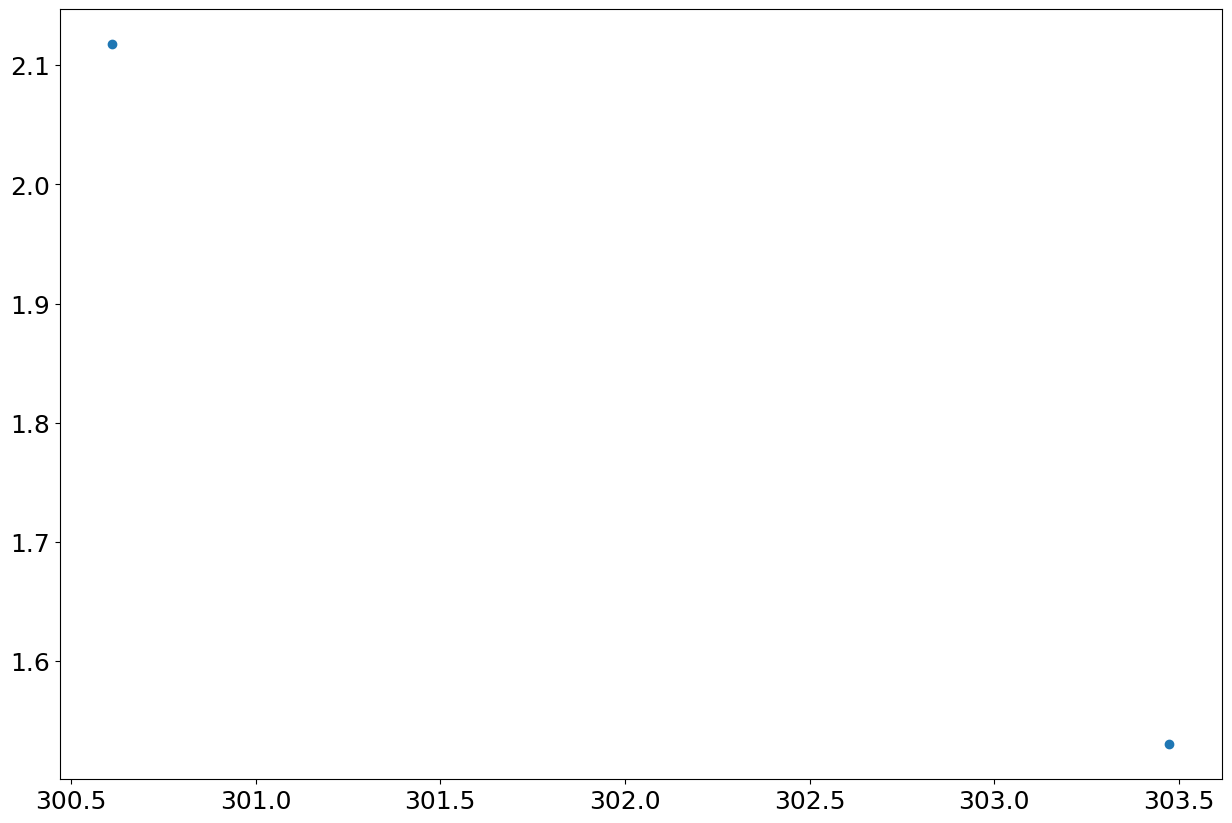

In [77]:
plt.scatter(dcd.sst_rms, dcd.B_hol)

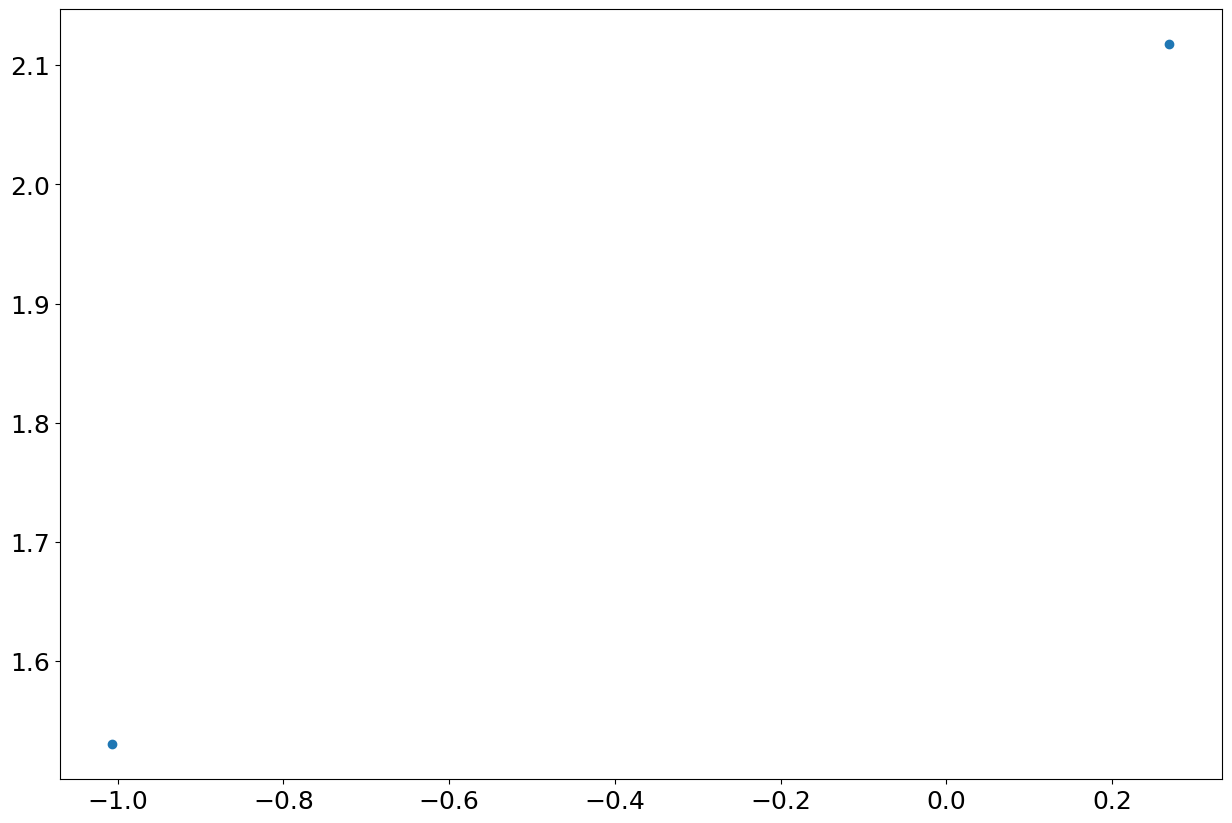

In [78]:
plt.scatter(dcd.oni_psl, dcd.B_hol)

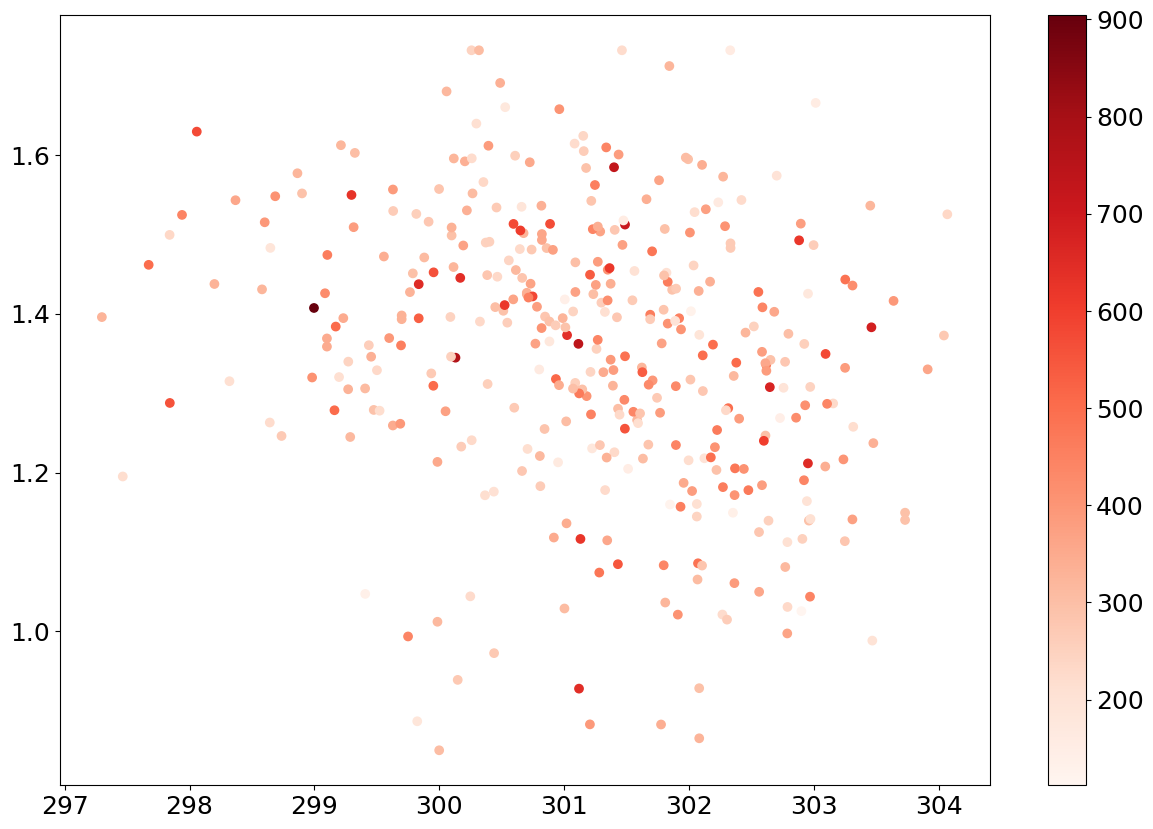

In [79]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)

plt.scatter(d.sst_rms, np.sqrt(d.B_hol), c=d.vmx ** 2 / np.sqrt(d.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

(array([ 22.,  84., 119.,  73.,  44.,  13.,  12.,   5.,   1.,   1.]),
 array([111.81231893, 191.05407388, 270.29582883, 349.53758377,
        428.77933872, 508.02109367, 587.26284861, 666.50460356,
        745.74635851, 824.98811345, 904.2298684 ]),
 <BarContainer object of 10 artists>)

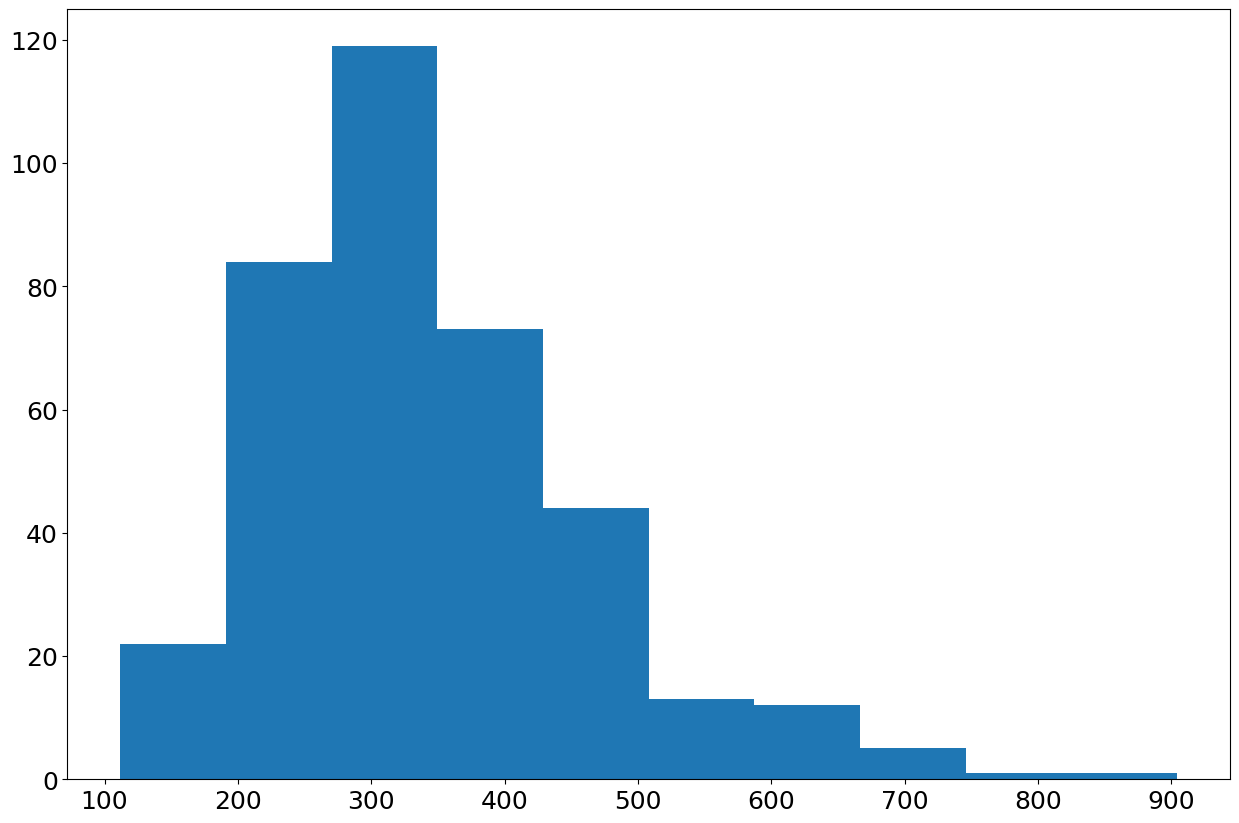

In [80]:
plt.hist(d.vmx ** 2 / np.sqrt(d.rsby))

In [81]:
cond = (d.vmx ** 2 / np.sqrt(d.rsby) > 280) & (d.vmx ** 2 / np.sqrt(d.rsby) < 320)
dcd  = d.where(cond, drop=True)

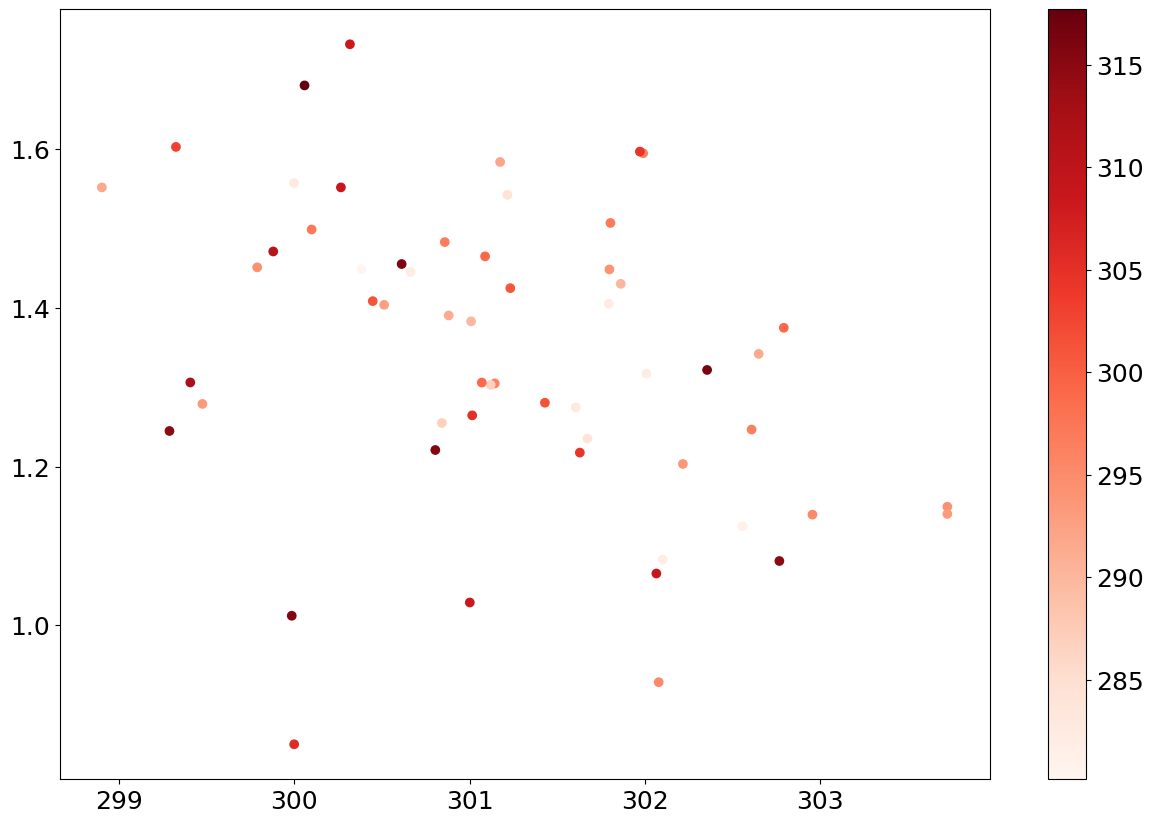

In [82]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)

plt.scatter(dcd.sst_rms, np.sqrt(dcd.B_hol), c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

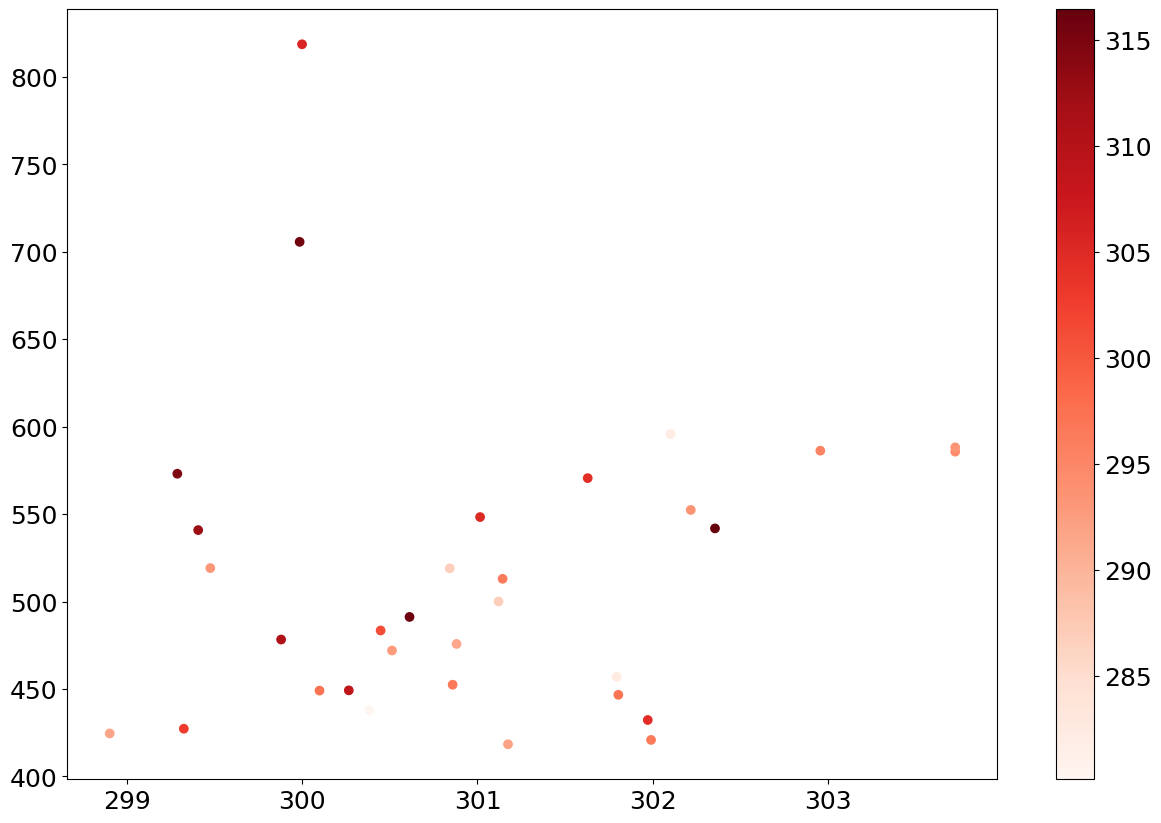

In [83]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)
# The uppermost case is an ERC

plt.scatter(dcd.sst_rms, dcd.beta0, c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

### 5) At the LMI

In [41]:
hrs_thr = 6 # threshold, in hours
dl      = d.where((d.t_since_lmi_ibt / 3600 > -hrs_thr) & (d.t_since_lmi_ibt / 3600 < hrs_thr), drop=True)
print(len(dl.time))

18


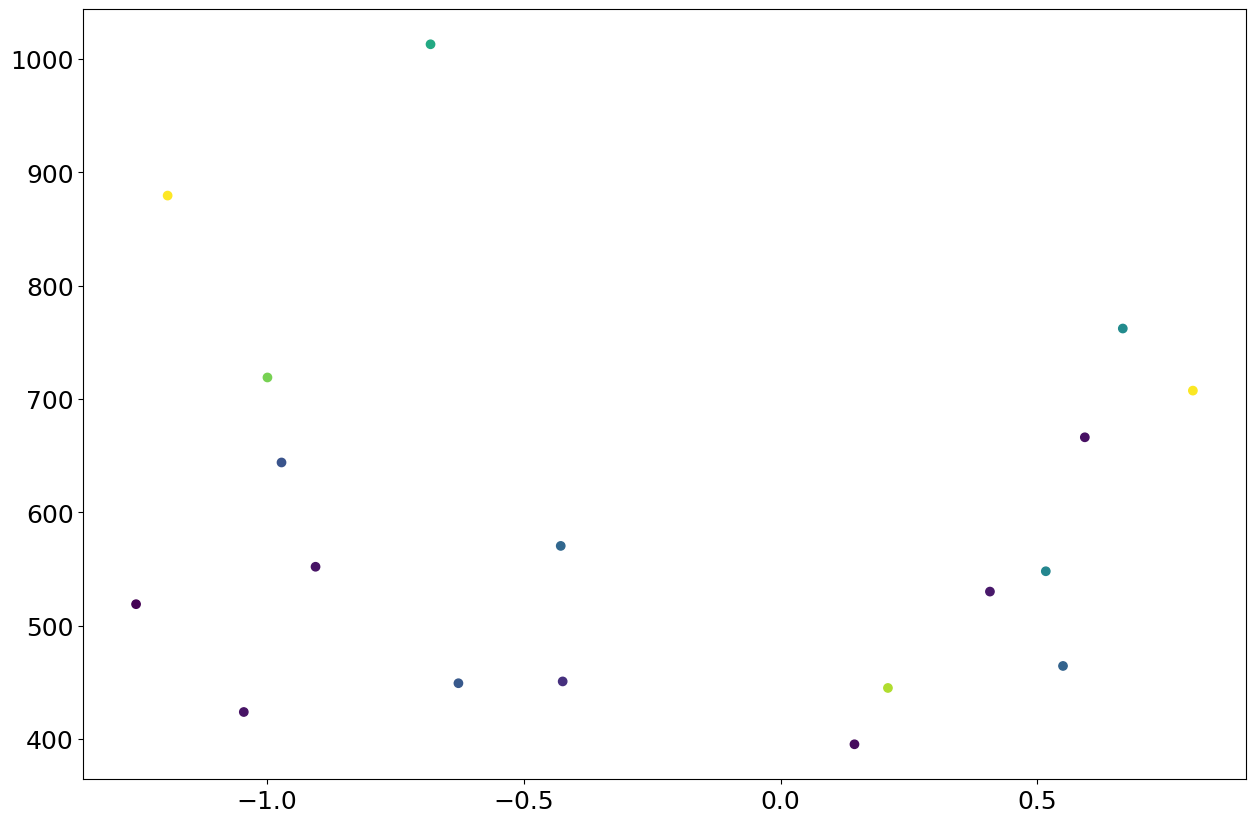

In [42]:
plt.scatter(dl.oni_psl, dl.beta0, c=abs(dl.fcor))

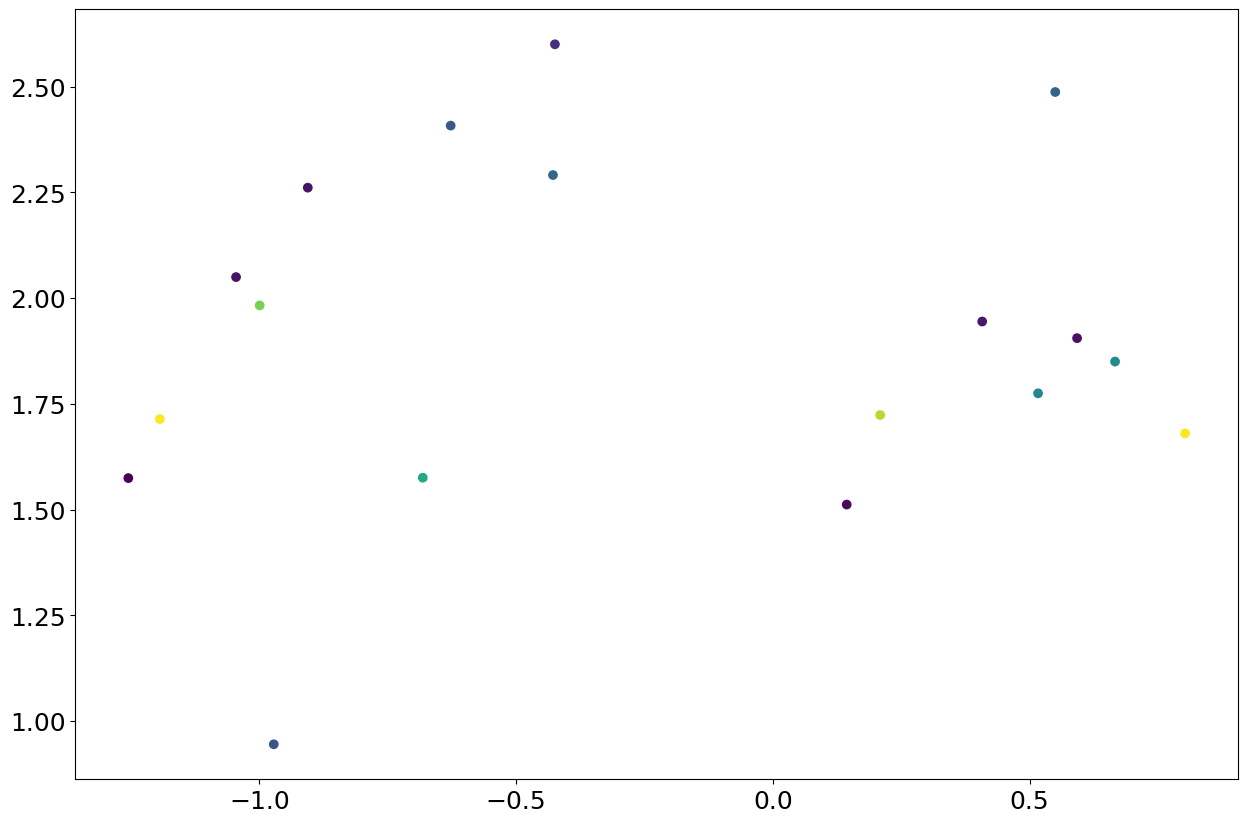

In [43]:
plt.scatter(dl.oni_psl, dl.B_hol, c=abs(dl.fcor))

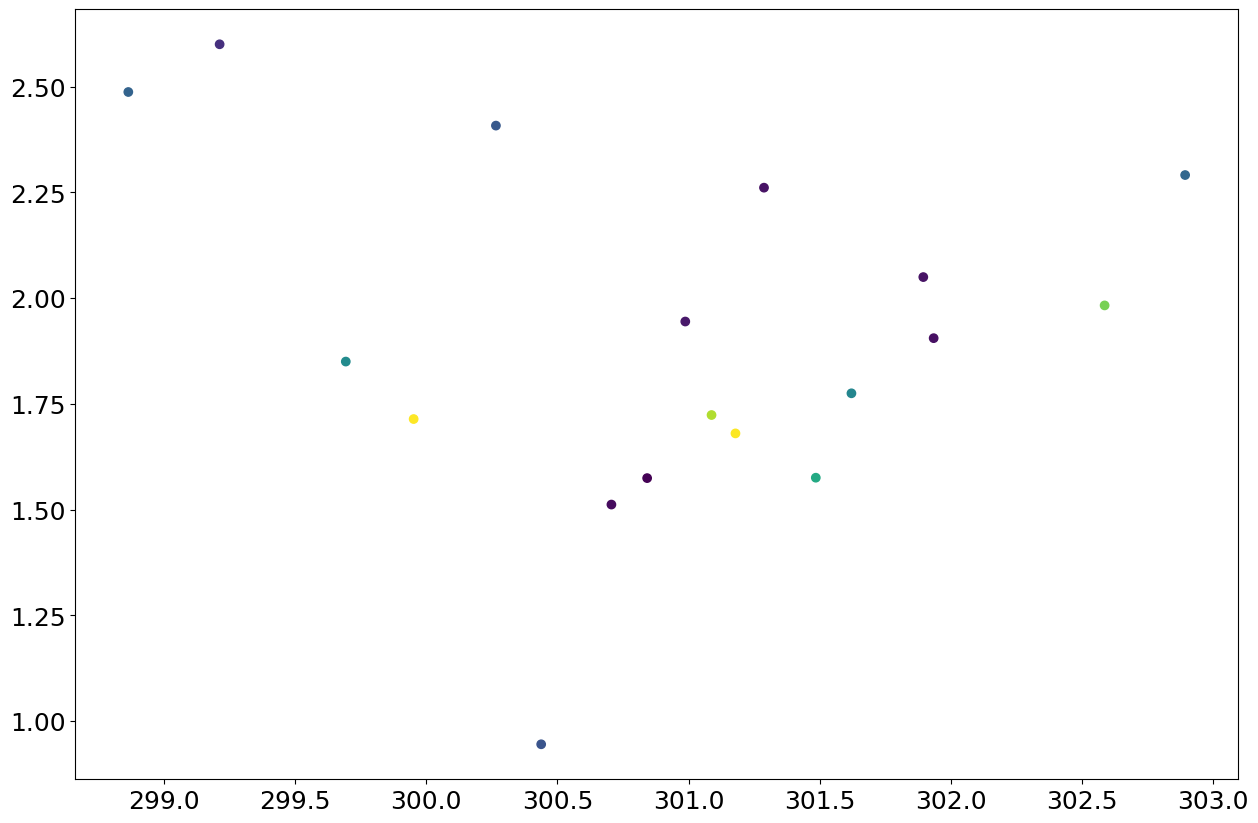

In [44]:
plt.scatter(dl.sst_rms, dl.B_hol, c=abs(dl.fcor))

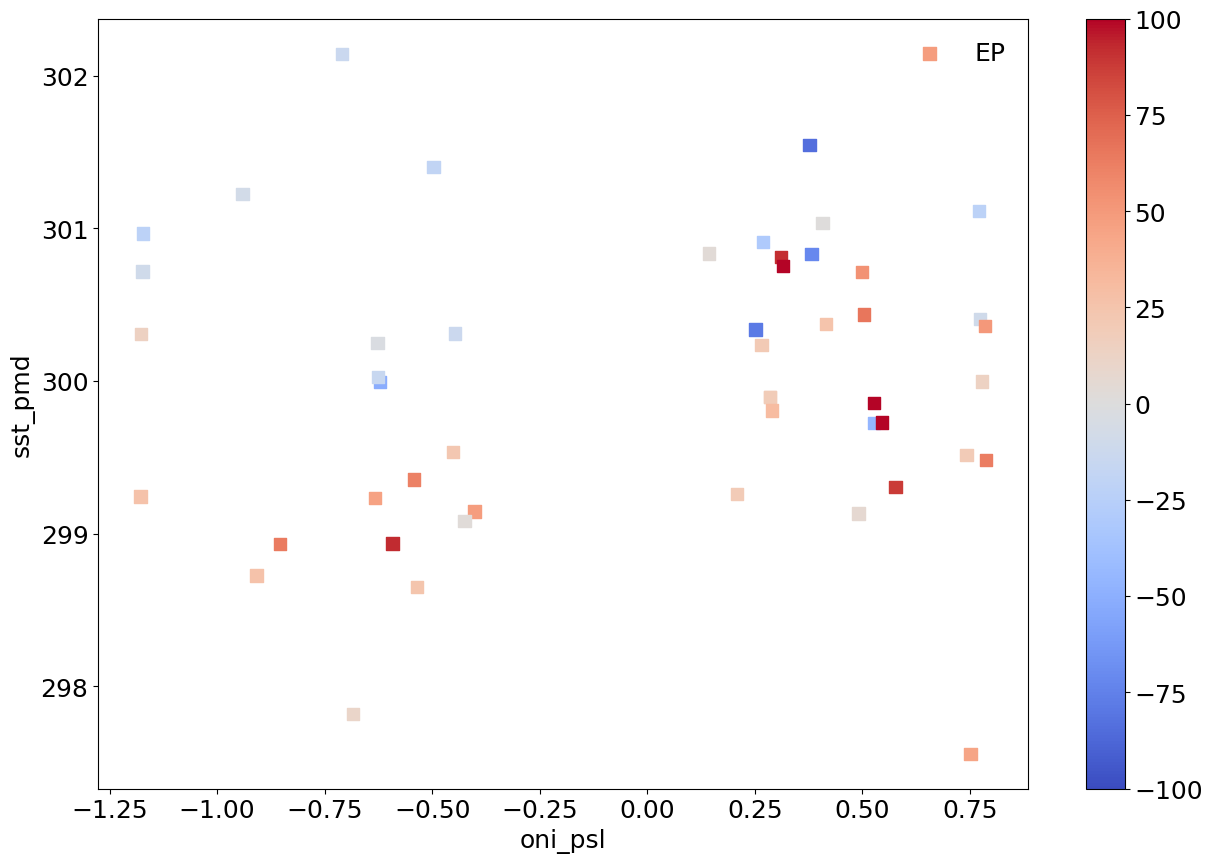

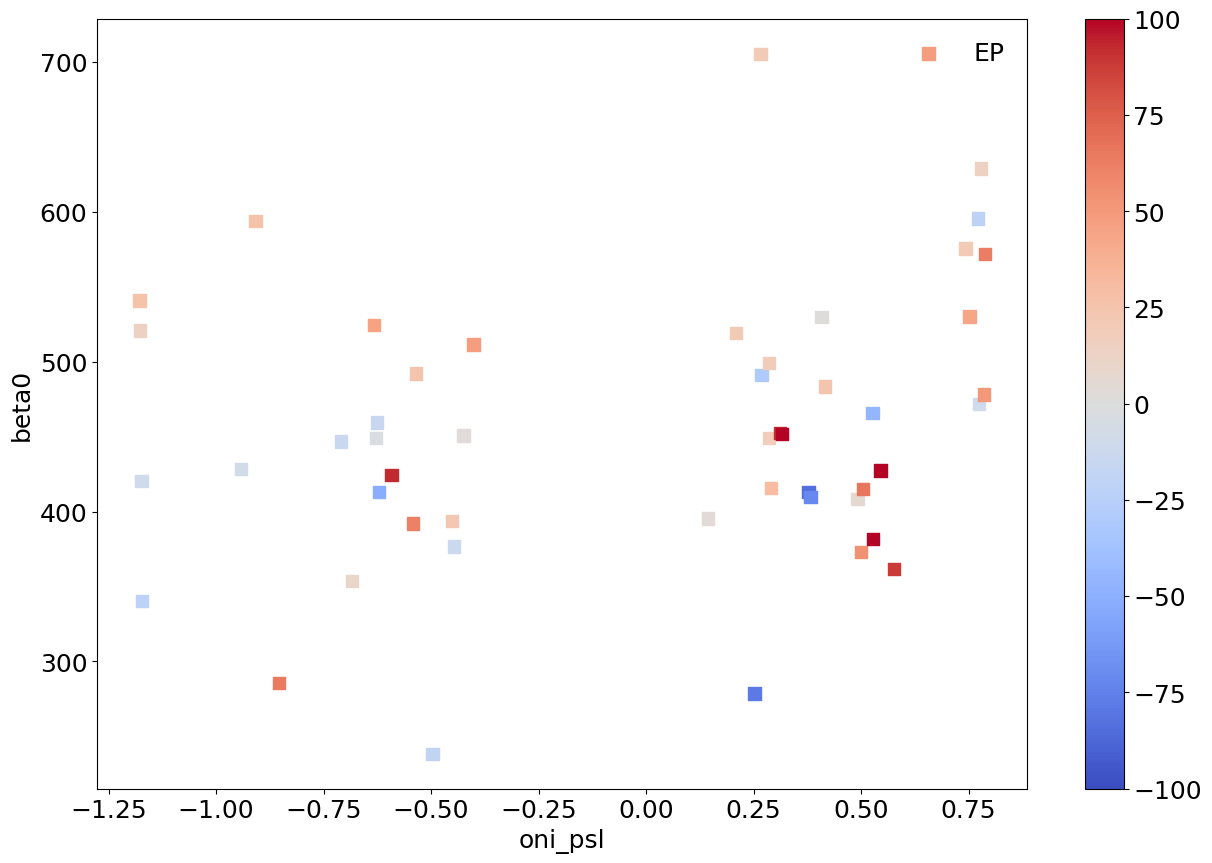

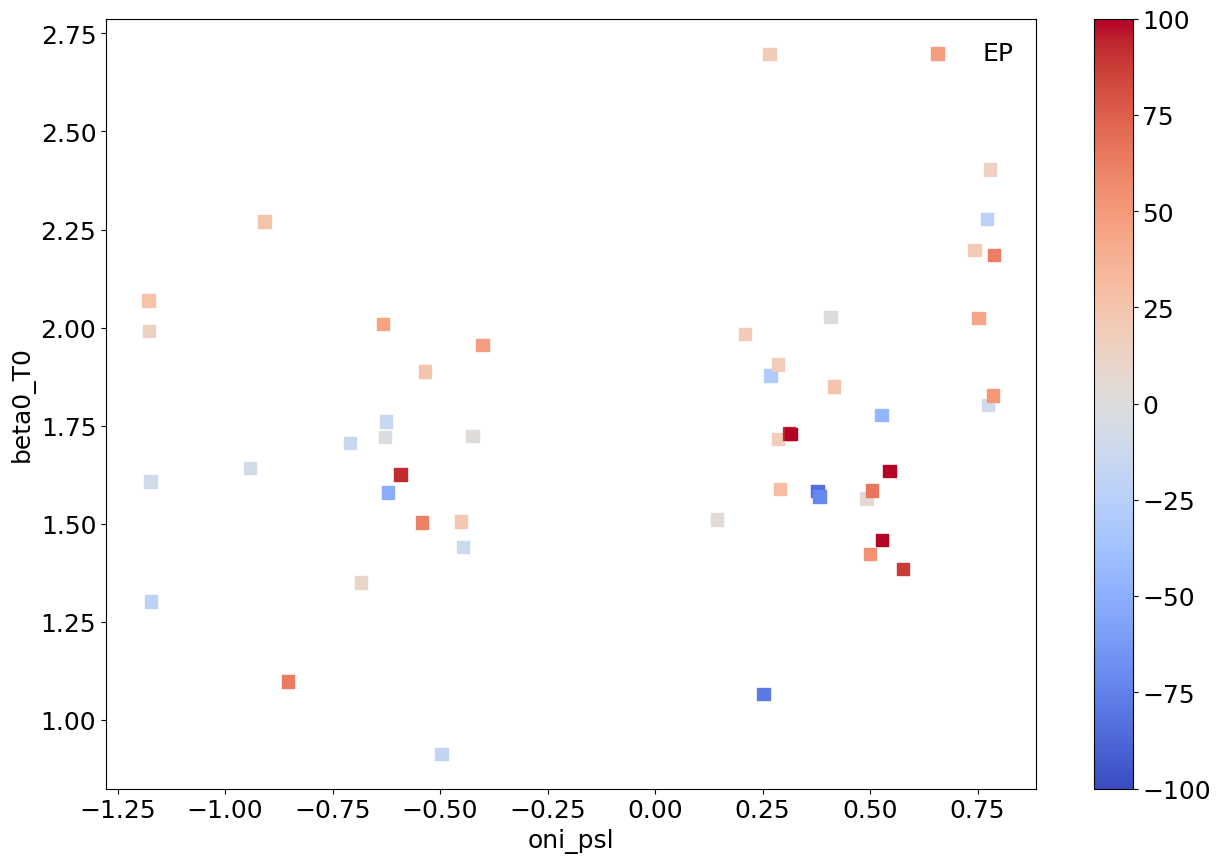

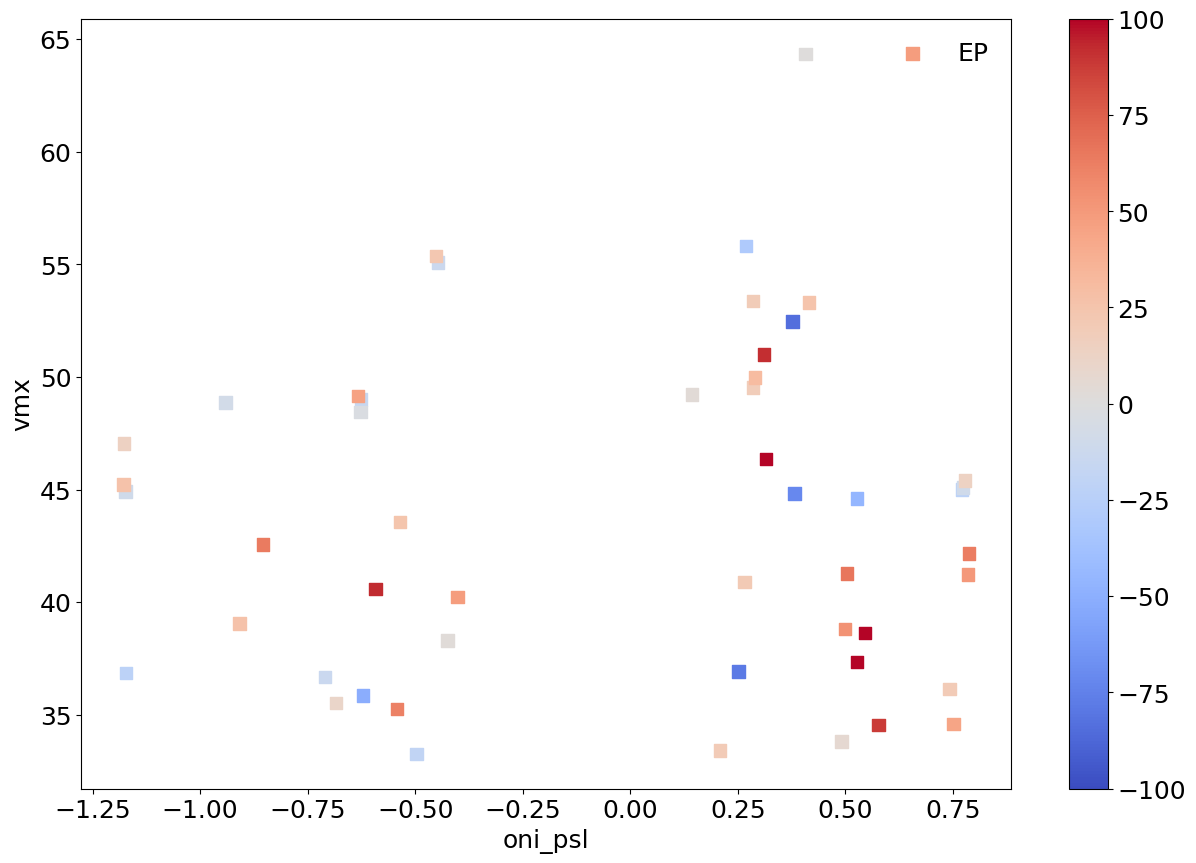

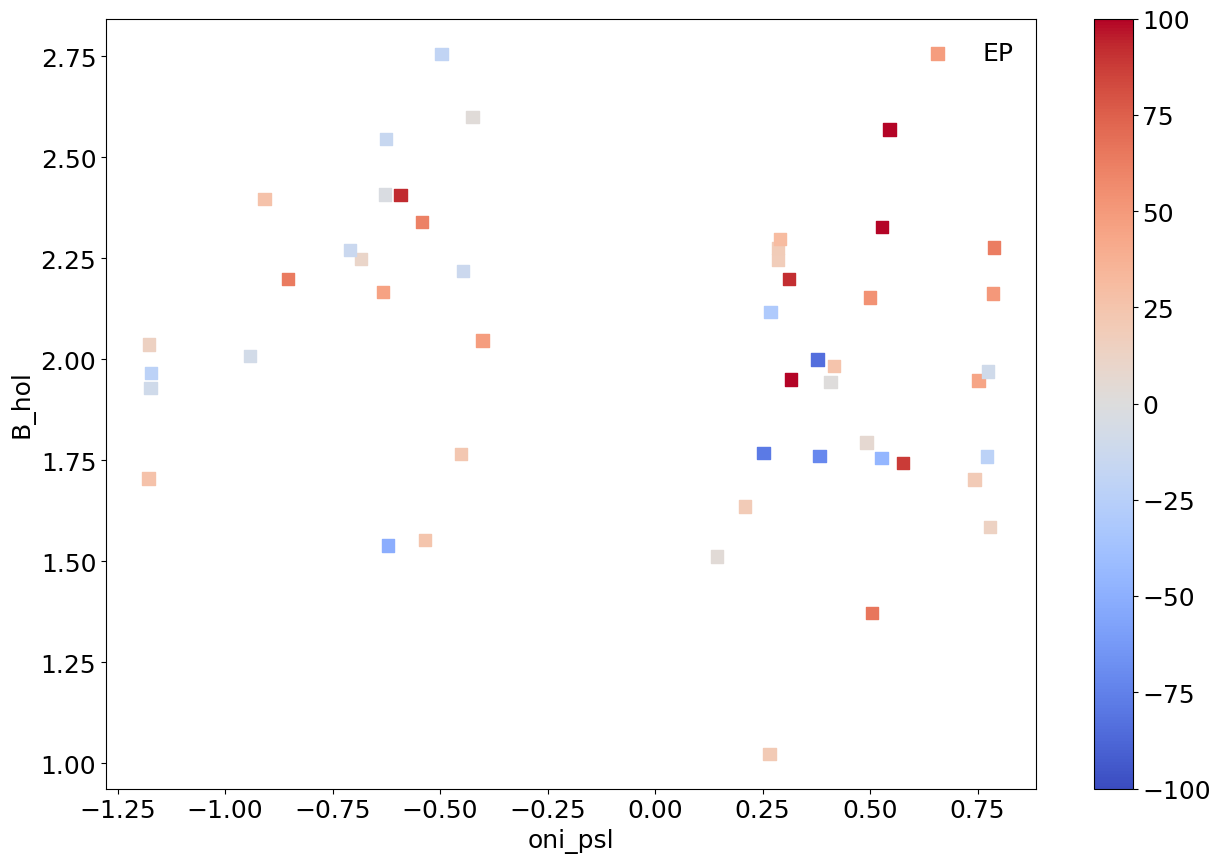

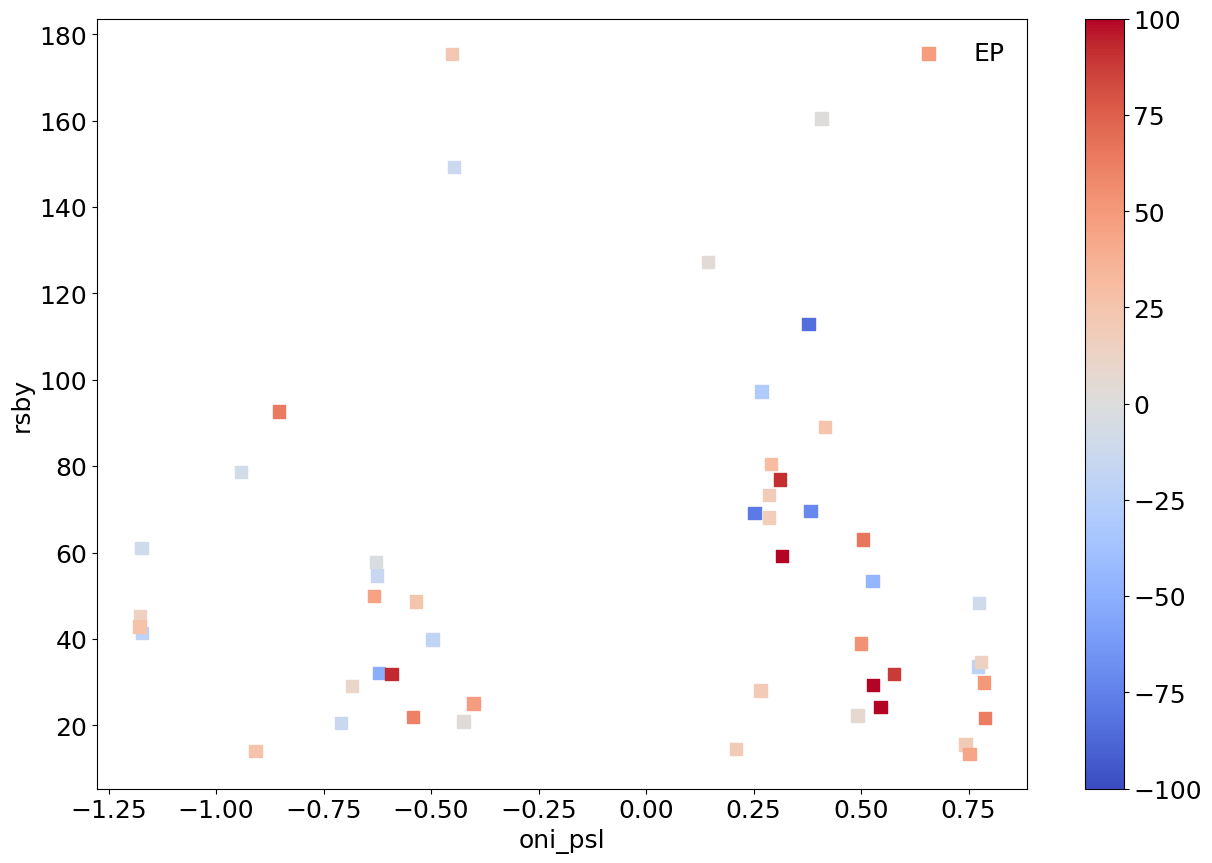

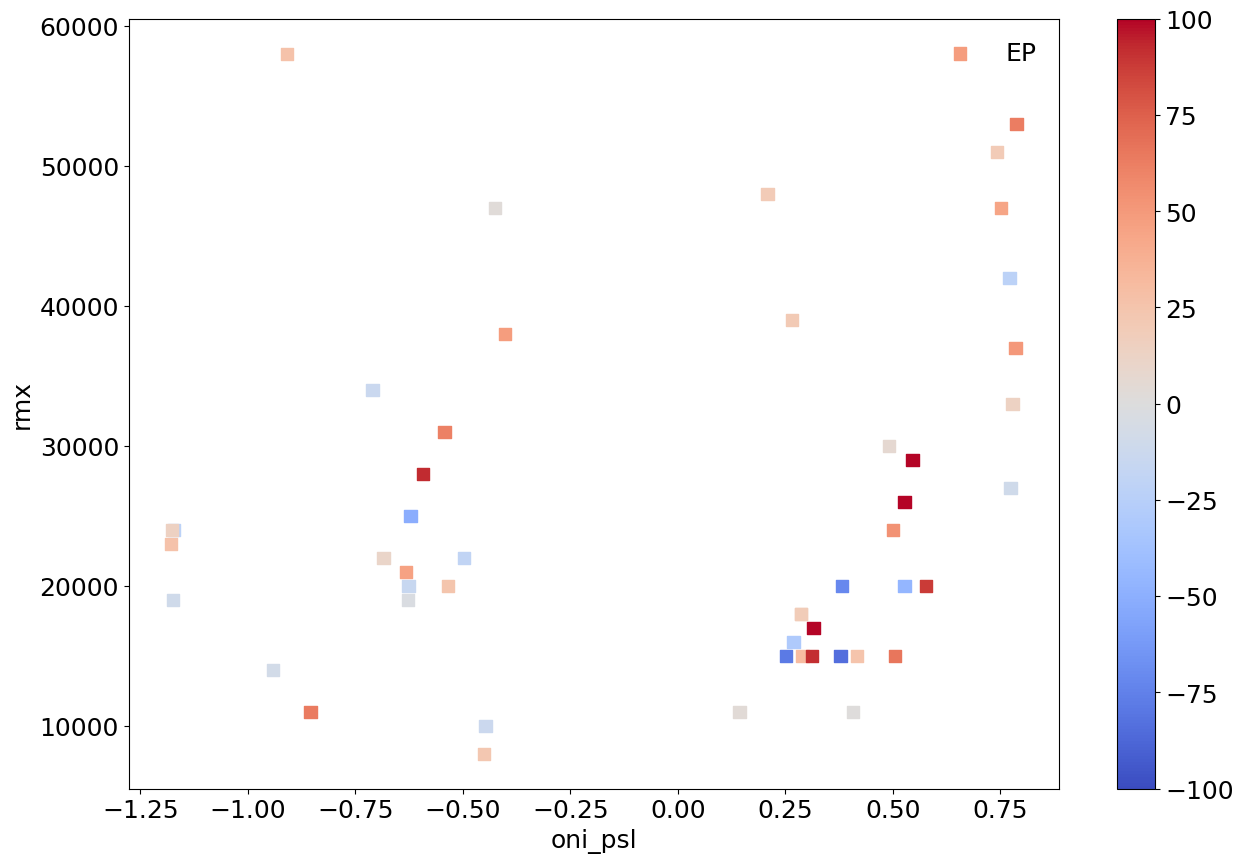

In [45]:
x = 'oni_psl'

for prm in ['sst_pmd', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(de[x], de[prm], c=de.t_since_lmi_ibt / 3600, marker='s', s=80, label='EP', cmap=cm.get_cmap('coolwarm'), vmin=-100, vmax=100)
    plt.colorbar()
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

(array([ 5.,  7.,  9., 14., 10.,  2.,  4.,  2.,  1.,  1.]),
 array([-65.48555557, -46.30155557, -27.11755557,  -7.93355557,
         11.25044443,  30.43444443,  49.61844443,  68.80244443,
         87.98644443, 107.17044443, 126.35444443]),
 <BarContainer object of 10 artists>)

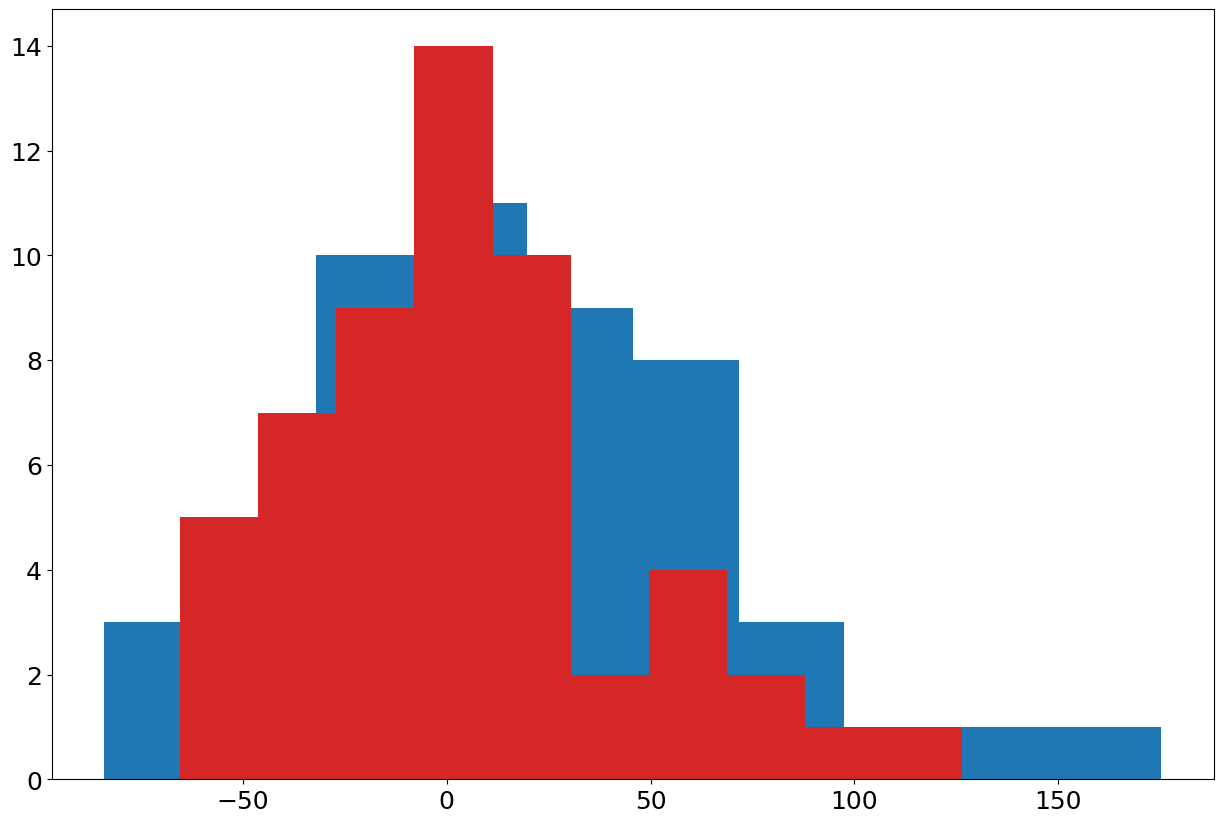

In [46]:
plt.hist(d.where(d.basin == 'ep', drop=True).t_since_lmi_ibt / 3600)
plt.hist(d.where(d.basin == 'wp', drop=True).t_since_lmi_ibt / 3600, color='tab:red')